In [ ]:
# Programa para leer archivos de mw radar

In [1]:
# import os
# import sys
# import glob
# import argparse
# import matplotlib
# import numpy as np
# import pandas as pd
# import xarray as xr
# import netCDF4 as nc
# import datetime as dt
# # from utils_gfat import plot
# from utils_gfat import plot
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# from distutils.dir_util import mkpath
# from matplotlib.dates import DateFormatter
# sys.path.append(os.path.join(os.getcwd(), 'utils_gfat', 'lidar_processing'))
# from lidar_processing import helper_functions

import os
import sys
import glob
import argparse
import matplotlib
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import datetime as dt
# from utils_gfat import plot
sys.path.append(r'G:\Mi unidad\03.PROGRAMAS\utils_gfat')
import plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from distutils.dir_util import mkpath
from matplotlib.dates import DateFormatter
sys.path.append(r'G:\Mi unidad\03.PROGRAMAS\utils_gfat\lidar_processing')
from lidar_processing import helper_functions

# from utils_gfat import rpg

ModuleNotFoundError: No module named 'plot'

In [2]:
def reader(filelist, filelistmet):
    """
    RPG Microwave Radiometer data reader. 
    Inputs:
    - filelist: List of radar files (i.e, '/drives/c/ZENITH*.TMP.NC') (str)
    Output:
    - mwr: Xarray dataframe (xarray) or 'None' in case of error.
    """
    
    def include_potential_temperature(mwr, filelistmet):
        """

        """    
        #Read meteo data
        metfiles2load = glob.glob(filelistmet)    
        if metfiles2load:     
            mwrmet = xr.open_mfdataset(metfiles2load)
            if mwrmet:            
                meanday_press = mwrmet.env_pressure.values.mean()
                meanday_temp = mwrmet.env_temperature.values.mean()
                if not meanday_press:
                    meanday_press = 960.
                if not meanday_temp :
                    meanday_temp  = 960.            
            else:
                meanday_press = 960.
                meanday_temp = 20.

            # Parámetros de atmósfera standard escalada
            T = np.ones(mwr.altitude_layers.values.size)*np.nan
            P = np.ones(mwr.altitude_layers.values.size)*np.nan
            for i,_height in enumerate(mwr.altitude_layers):                
                sa = helper_functions.standard_atmosphere(_height, meanday_temp, meanday_press)                
                P[i]  = sa[0]
                T[i]  = sa[1] 

            pressure_ratio = np.power((1000./P),0.286)
            pot_temp = (mwr.temperature_profiles+273.15)*np.tile(pressure_ratio, (mwr.temperature_profiles.shape[0],1)) - 273.15

            mwr['potential_temperature_profiles'] = pot_temp
            mwr['potential_temperature_profiles'].attrs['units'] = '$^{\circ}$C'
            mwr['potential_temperature_profiles'].attrs['long_name'] = 'Potential temperature'
            mwr['potential_temperature_profiles'].attrs['pressure_ratio'] = pressure_ratio
            mwr['potential_temperature_profiles'].attrs['pressure'] = P
        #     print('Potential temperature has been added.')
        return mwr
        
    #Date format conversion
    files2load = glob.glob(filelist)    

    if files2load:        
        print(files2load)

        #Extract information from filename   
#         parts = os.path.basename(files2load[0]).split('_')
#         print(parts)
#         infofile = {'radarNick': parts[0], 'stationNick': parts[1]}        

        #Load data
        mwr = []
        tmp_mwr = xr.open_mfdataset(files2load)
        if tmp_mwr:
            mwr0 = tmp_mwr.assign_coords(number_altitude_layers=tmp_mwr.altitude_layers.values)        
            mwr = mwr0.rename({'number_altitude_layers': 'altitude'})        
            #Encoding time as python datetime
            mwr['time'].attrs['long_name'] = 'Date, UTC'
            mwr['time'].attrs['units'] = 'Datetime'        
            mwr = mwr.sortby(mwr['time'])                    
            if not 'location' in mwr.attrs.keys():
                mwr.attrs['location'] = 'Granada'
                print('Granada added as location attribute.')

            mwr['temperature_profiles'] = mwr['temperature_profiles'] - 273.15
            mwr['temperature_profiles'].attrs['units'] = '$^{\circ}$C'
            infofile = {'stationNick': 'gr','mwrNick': 'mwr'} #Creo que esto no hace falta y complica la función así que lo quitaría.

            mwr = include_potential_temperature(mwr, filelistmet)
        else:
            mwr = None
    else:
        mwr = None
        infofile = None
#     mwr.close()
    return mwr, infofile

In [3]:
# def potential_temperature(filelist, filelistmet):
#     """
    
#     """    
#     #Read meteo data
#     mwrmet, infofilemet = reader(filelistmet)
#     if mwrmet:            
#         meanday_press = 10*mwrmet.env_pressure.values.mean()
#         meanday_temp = mwrmet.env_temperature.values.mean()
#         if not meanday_press:
#             meanday_press = 960.
#         if not meanday_temp :
#             meanday_temp  = 960.            
#     else:
#         meanday_press = 960.
#         meanday_temp = 273+20.
    
#     #Read temperature profile
#     mwr, infofile = reader(filelist)
#     if not mwr:
#         mwr = None
#         return
      
#     # Parámetros de atmósfera standard escalada
#     T = np.ones(mwr.altitude_layers.values.size)*np.nan
#     P = np.ones(mwr.altitude_layers.values.size)*np.nan
#     for i,_height in enumerate(mwr.altitude_layers):
#         sa = helper_functions.standard_atmosphere(_height, meanday_temp, meanday_press)
#         P[i]  = sa[0]
#         T[i]  = sa[1] 

#     pressure_ratio = np.power((meanday_press/P),0.286)
#     pot_temp = mwr.temperature_profiles*np.tile(pressure_ratio, (mwr.temperature_profiles.shape[0],1)) - 273.15
        
#     mwr['potential_temperature_profiles'] = pot_temp
#     mwr['potential_temperature_profiles'].attrs['units'] = '$^{\circ}$C'
#     mwr['potential_temperature_profiles'].attrs['long_name'] = 'Potential temperature'
# #     print('Potential temperature has been added.')
#     return mwr

In [4]:
# def plot_mwr_potential_temperature(filelist, filelistmet):

#     """
#     Calculation of Potential Temperature of RPG MWR measurements.    
#     Inputs:
#     - filelist: List of mwr files (i.e, '/drives/c/ZENITH*.MET.NC', 'ZENITH*.CMP.TPC.NC') (str)
#     - variables2plot: mwr variables. (integer)
#     Outputs:
#     - None
#     """
#     #Font size of the letters in the figure
#     matplotlib.rcParams.update({'font.size': 20})
    
#     # Read the list of files to plot
#     # --------------------------------------------------------------------
# #     infofile
# #         infofile = {'radarNick': parts[0], 'stationNick': parts[1], 'datestr': parts[2], 'timestr': parts[3]}

    
#     return mwr, infofile
    

In [3]:
def plot_mwr_variables(filelist, filelistmet, variables2plot, plt_conf, figdirectory):
    """
    Quicklook maker of RPG MWR measurements.    
    Inputs:
    - filelist: List of mwr files (i.e, '/drives/c/ZENITH*.TMP.NC') (str)
    - variables2plot: mwr variables. (integer)
    Outputs:
    - None
    """
    ###############################################################################
    #Define colorbar    
    bottom = matplotlib.cm.get_cmap('cool', 90)  #Cool
    middle = matplotlib.cm.get_cmap('winter', 30)  #Winter
    top = matplotlib.cm.get_cmap('inferno', 80) #'Spectral'    #Inferno
    lsbottom = np.flip(bottom(np.linspace(0, 1, 90)),axis=0)
#     lsbottom = bottom(np.linspace(0, 1, 90))
    lsmiddle = middle(np.linspace(0, 1, 30))
#     lsmiddle = np.flip(middle(np.linspace(0, 1, 30)),axis=0)
    lstop = np.flip(top(np.linspace(0, 1, 80)),axis=0)
#     lstop = top(np.linspace(0, 1, 80))
    newcolors = np.vstack((lsbottom, lsmiddle , lstop ))    
    mwr_cmap = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')
    ###############################################################################
       
    #Dictionaries
    #Variables that can be plotted     
    var2plot = {0: 'temperature_profiles', 1: 'potential_temperature_profiles'} #, 3: 'sigma', 4: 'kurt'
    #Mininum value on the colorbar
    Vmin = {0: -60, 1: 0}#, 1: -5, 2: 0} #, 3: -3, 4: -3
    #Maximum value on the colorbar
    Vmax = {0: 40, 1: 50}#, 1: 5, 2: 5} #, 3: 3, 4: 3
    #Variable name to be written in the title of the figure
    titleStr = {0: 'Temperature', 1: 'Potential Temperature'}#, 1: 'vertical mean velocity', 2: 'spectral width'}
    #Variable name to be written in the ylabel of the colorbar
    ylabelbar = {0: 'Temperature,$\degree$$C$', 1: 'Temperature,$\degree$$C$'}#, 1: 'Vertical mean velocity, $[m/s]$', 2: 'Doppler spectral with, $[m/s]$'}
    cbar = {0:mwr_cmap, 1:matplotlib.cm.jet}
    #Font size of the letters in the figure
    matplotlib.rcParams.update({'font.size': 20})
    
    # Read the list of files to plot
    # --------------------------------------------------------------------
    mwr, infofile = reader(filelist, filelistmet)   

    if mwr != None:
        # One figure per variable
        # --------------------------------------------------------------------
        for idx in variables2plot:
            var_ = var2plot[idx]
#             print(mwr[var_])
            print('Current plot %s' % var_)
            # #Create Figure
            fig = plt.figure(figsize=(20,10))
            axes = fig.add_subplot(111)    
            #Plot        
            cmap = mwr_cmap
            cmap.set_under("crimson")
            cmap.set_over("w")
            bounds = np.linspace(Vmin[idx], Vmax[idx], 128)
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            range_km = mwr['altitude_layers']/1000.
            q = axes.pcolormesh(mwr['time'], range_km, mwr[var_].T,
                                cmap=cbar[idx],
                                norm=norm,
                                vmin=Vmin[idx],
                                vmax=Vmax[idx],
                                shading='flat')

#             axes.pcolormesh(mwr['time'], range_km, mwr_zero.T - 273.)
            q.cmap.set_under('magenta')
            q.cmap.set_over('black')
            # q.update_ticks()
            cb = plt.colorbar(q, ax=axes, ticks = np.arange(Vmin[idx], Vmax[idx], 10),  extend='both')
            
            
            # search for gaps in data
            # --------------------------------------------------------------------     
            if plt_conf['gapsize'] == 'default':        
                dif_time = mwr['time'].values[1:] - mwr['time'].values[0:-1]                   
                GAP_SIZE = 2*int(np.ceil((np.median(dif_time).astype('timedelta64[s]').astype('float')/60))) #GAP_SIZE is defined as the median of the resolution fo the time array (in minutes)        
                print('GAP_SIZE parameter automatically retrieved to be %d.' % GAP_SIZE)         
            else:
                GAP_SIZE = int(plt_conf['gapsize'])
                print('GAP_SIZE set by the user: %d (in minutes)' % GAP_SIZE)     
            dttime = np.asarray([dt.datetime.utcfromtimestamp((time_ - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')) for time_ in  mwr['time'].values])
            plot.gapsizer(axes, dttime, range_km, GAP_SIZE, '#c7c7c7')

            # Setting axes 
            # --------------------------------------------------------------------
            mf = matplotlib.ticker.FuncFormatter(plot.tmp_f)
            axes.xaxis.set_major_formatter(mf)
            hours = mdates.HourLocator(range(0, 25, 3))
            date_fmt = mdates.DateFormatter('%H')
            axes.xaxis.set_major_locator(hours)
            axes.xaxis.set_major_formatter(date_fmt)        
            min_date = mwr['time'].values.min()
            max_date = mwr['time'].values.max()
            axes.set_xlim(min_date  -  np.timedelta64(minutes=30), max_date +  -  np.timedelta64(hours=23, minutes=59, seconds=59))            
            axes.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval = 1))
            axes.set_ylim(plt_conf['y_min'], plt_conf['y_max'])
            plt.grid(True)
            axes.set_xlabel('Time, $[UTC]$')
            axes.set_ylabel('Altitude, $[km]$')
            cb.ax.set_ylabel(ylabelbar[idx])
        
            # title
            # ----------------------------------------------------------------------------
            plt_conf['title1'] = 'Microwave Radiometer %s' % var_ #titleStr[idx]
            plot.title1(plt_conf['title1'], plt_conf['coeff'])
            datestr = mwr['time'].values.min().astype('str').split('T')[0]
            print('Datestr:',datestr)
            plot.title2(datestr, plt_conf['coeff'])
            if not 'location' in plt_conf:
                loc = {'gr': 'Granada'} 
                plt_conf['location'] = loc[infofile['stationNick']]

            plot.title3('{} ({:.1f}N, {:.1f}E)'.format(plt_conf['location'], float(mwr.station_latitude[1:3]), float(mwr.station_longitude[1:2])), plt_conf['coeff'])

            # logo
            # ----------------------------------------------------------------------------
            plot.add_GFAT_logo([0.85, 0.01, 0.15, 0.15])
                                
            # Font Size
            # ----------------------------------------------------------------------------
            # for item in ([axes.title, axes.xaxis.label, axes.yaxis.label] +
            #              axes.get_xticklabels() + axes.get_yticklabels()):
            #     item.set_fontsize(20)    
            
            # Saver figure
            # ----------------------------------------------------------------------------           
            debugging = False
            
            if debugging:
                plt.show()
            else:            
                #create output folder
                # --------------------------------------------------------------------
                year = datestr.replace('-','')[0:4]
                fulldirpath = os.path.join(figdirectory, year, var_) 
                if np.logical_not(os.path.exists(fulldirpath)):
                    mkpath(fulldirpath)
                    print('fulldirpath created: %s' % fulldirpath)                
                figstr = '%s_%s_%s_%s.png' % (infofile['mwrNick'], infofile['stationNick'], var_, datestr.replace('-',''))
                finalpath = os.path.join(fulldirpath, figstr)
                print('Saving %s' % finalpath)
                plt.savefig(finalpath, dpi=100, bbox_inches = 'tight')
                if os.path.exists(finalpath):
                    print('Saving %s...DONE!' % finalpath)
                else:
                    print('Saving %s... error!' % finalpath)
        mwr.close()
    else:
        print('ERROR: files not found with format: %s' % filelist)
    return

In [4]:
# maindir_mwr = 'Y:\datos\RPG-HATPRO\Data\Y2019\M07\D28'
maindir_mwr = 'Y:\datos\RPG-HATPRO\Data\Y2019\M08\D05'
mwrfile = 'ZENITH_*.CMP.TPC.NC'
mwrmet = 'ZENITH_*.MET.NC'

In [5]:
mwr, info = reader(os.path.join(maindir_mwr,mwrfile), os.path.join(maindir_mwr,mwrmet))

['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M08\\D05\\ZENITH_190805.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


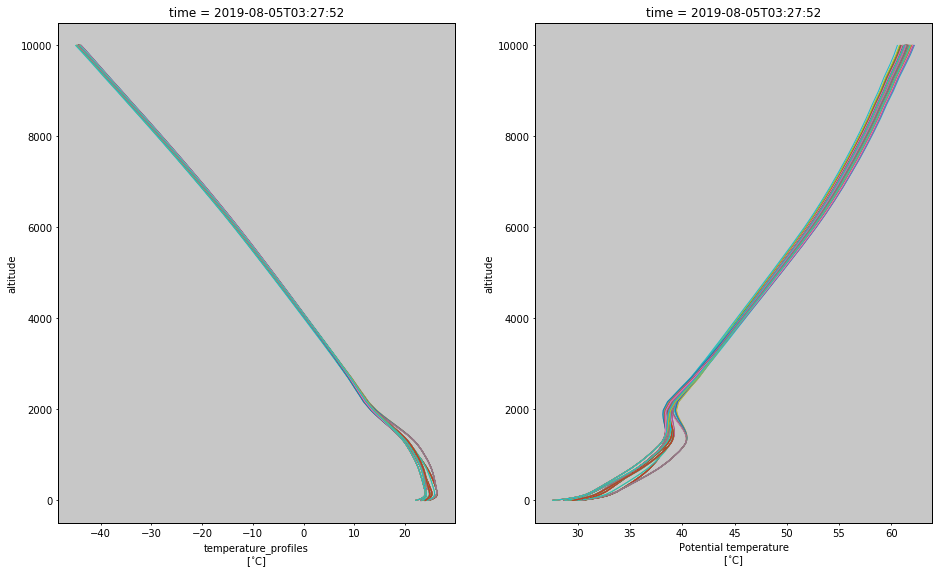

In [8]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
for idx in np.arange(100):
    mwr.temperature_profiles[idx].plot(y='altitude',ax=ax)
ax = plt.subplot(1,2,2)
for idx in np.arange(100):
    mwr.potential_temperature_profiles[idx].plot(y='altitude',ax=ax)

In [6]:
figdir = os.getcwd()

In [7]:
print(figdir)

G:\Mi unidad\03.PROGRAMAS\Radar


['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M08\\D05\\ZENITH_190805.CMP.TPC.NC']
Granada added as location attribute.
Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-08-05


C:\Users\fizic\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving D:\My Drive go.ugr.es\07. Software\jupyter\2019\temperature_profiles\mwr_gr_temperature_profiles_20190805.png
Saving D:\My Drive go.ugr.es\07. Software\jupyter\2019\temperature_profiles\mwr_gr_temperature_profiles_20190805.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-08-05
Saving D:\My Drive go.ugr.es\07. Software\jupyter\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20190805.png
Saving D:\My Drive go.ugr.es\07. Software\jupyter\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20190805.png...DONE!


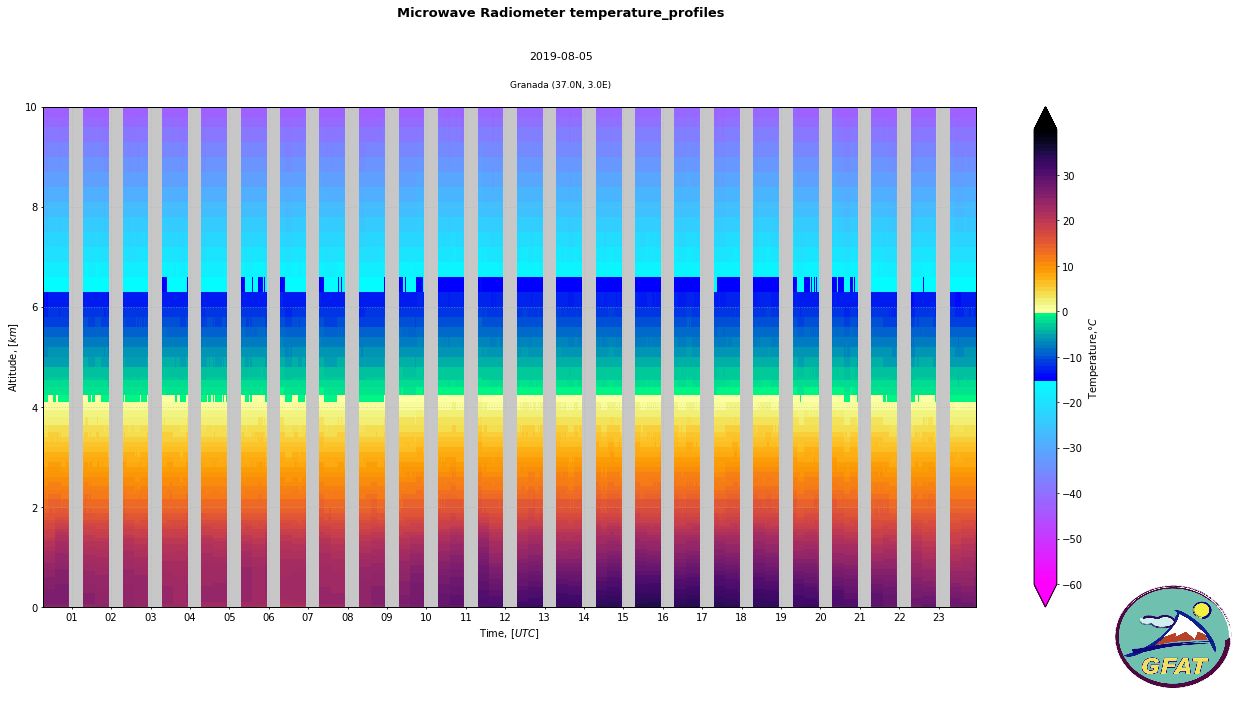

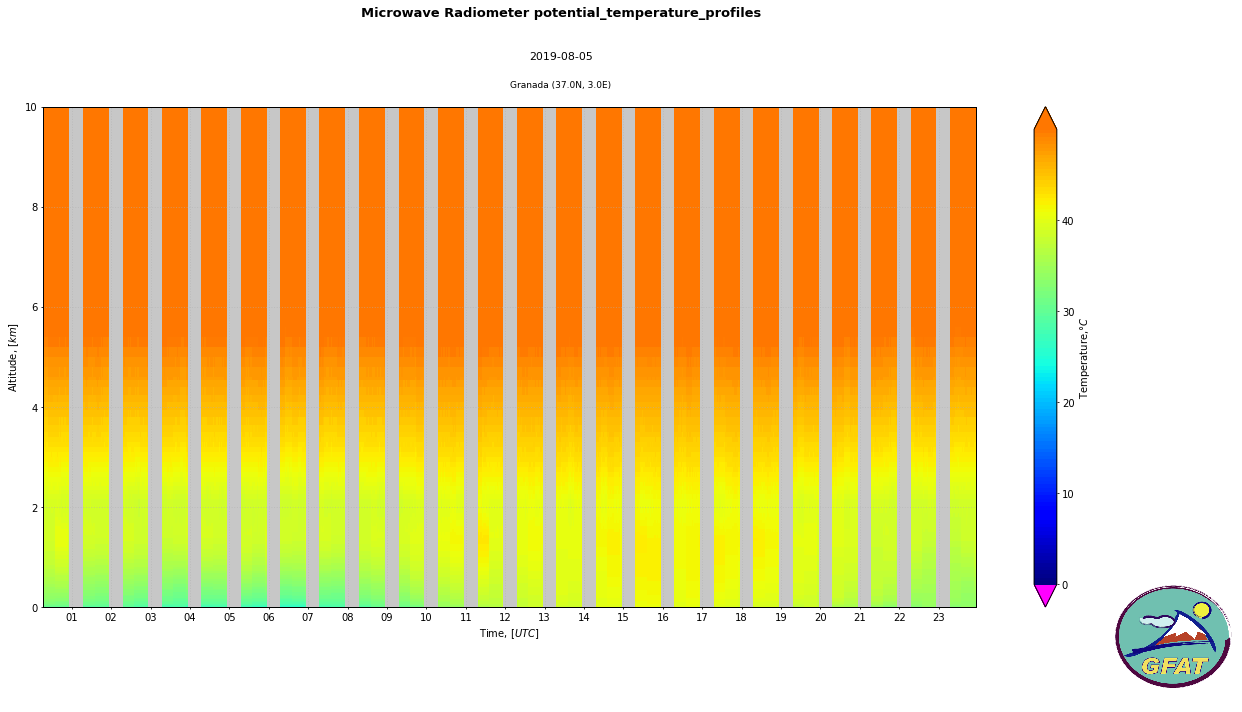

In [16]:
def daily_quicklook(filelist, figdirectory):    
    figdir = os.getcwd()
    plt_conf = {}
    plt_conf['gapsize'] = 'default'
    plt_conf['y_min'] = 0.
    plt_conf['y_max'] = 10.
    plt_conf['coeff'] = 2.   
    variables2plot = (0,1)
    a3 = plot_mwr_variables(os.path.join(maindir_mwr,mwrfile), os.path.join(maindir_mwr,mwrmet), variables2plot, plt_conf, figdir)


['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D01\\ZENITH_191101.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-01
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191101.png


C:\Users\Marta\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191101.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-01
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191101.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191101.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D1\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D02\\ZENITH_191102.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-02
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191102.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191102.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-02
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191102.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191102.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D2\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D03\\ZENITH_191103.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-03
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191103.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191103.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-03
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191103.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191103.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D3\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D04\\ZENITH_191104.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-04
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191104.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191104.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-04
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191104.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191104.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D4\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D05\\ZENITH_191105.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-05
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191105.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191105.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-05
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191105.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191105.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D5\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D06\\ZENITH_191106.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-06
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191106.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191106.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-06
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191106.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191106.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D6\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D07\\ZENITH_191107.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-07
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191107.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191107.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Datestr: 2019-11-07
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191107.png
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191107.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D7\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D08\\ZENITH_191108.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-08
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191108.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191108.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-08
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191108.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191108.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D8\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D09\\ZENITH_191109.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-09
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191109.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191109.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-09
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191109.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191109.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D9\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D010\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D10\\ZENITH_191110.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-10
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191110.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191110.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-10
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191110.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191110.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D011\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D11\\ZENITH_191111.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-11
fichier graphGFAT : Impossible d'inclure le logo !!!!!

C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future



Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191111.png
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191111.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-11
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191111.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191111.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D012\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D12\\ZENITH_191112.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-12
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191112.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191112.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-12
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191112.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191112.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D013\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D13\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D014\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D14\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D015\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D15\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D016\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D16\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D017\ZENITH_*.CM

C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-27
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191127.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191127.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-27
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191127.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191127.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D028\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D28\\ZENITH_191128.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-28
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191128.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191128.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-28
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191128.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191128.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D029\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D29\\ZENITH_191129.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-29
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191129.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191129.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-29
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191129.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191129.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D030\ZENITH_*.CMP.TPC.NC
['Y:\\datos\\RPG-HATPRO\\Data\\Y2019\\M11\\D30\\ZENITH_191130.CMP.TPC.NC']


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Granada added as location attribute.


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

C:\Users\Marta\Anaconda3\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Current plot temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-30
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191130.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\temperature_profiles\mwr_gr_temperature_profiles_20191130.png...DONE!
Current plot potential_temperature_profiles
GAP_SIZE parameter automatically retrieved to be 4.
<class 'numpy.ndarray'>
Datestr: 2019-11-30
fichier graphGFAT : Impossible d'inclure le logo !!!!!
Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191130.png


C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Saving G:\Mi unidad\00.INVESTIGACION\RADAR\Quicklooks\2019\potential_temperature_profiles\mwr_gr_potential_temperature_profiles_20191130.png...DONE!
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D031\ZENITH_*.CMP.TPC.NC
ERROR: files not found with format: Y:\datos\RPG-HATPRO\Data\Y2019\M11\D31\ZENITH_*.CMP.TPC.NC


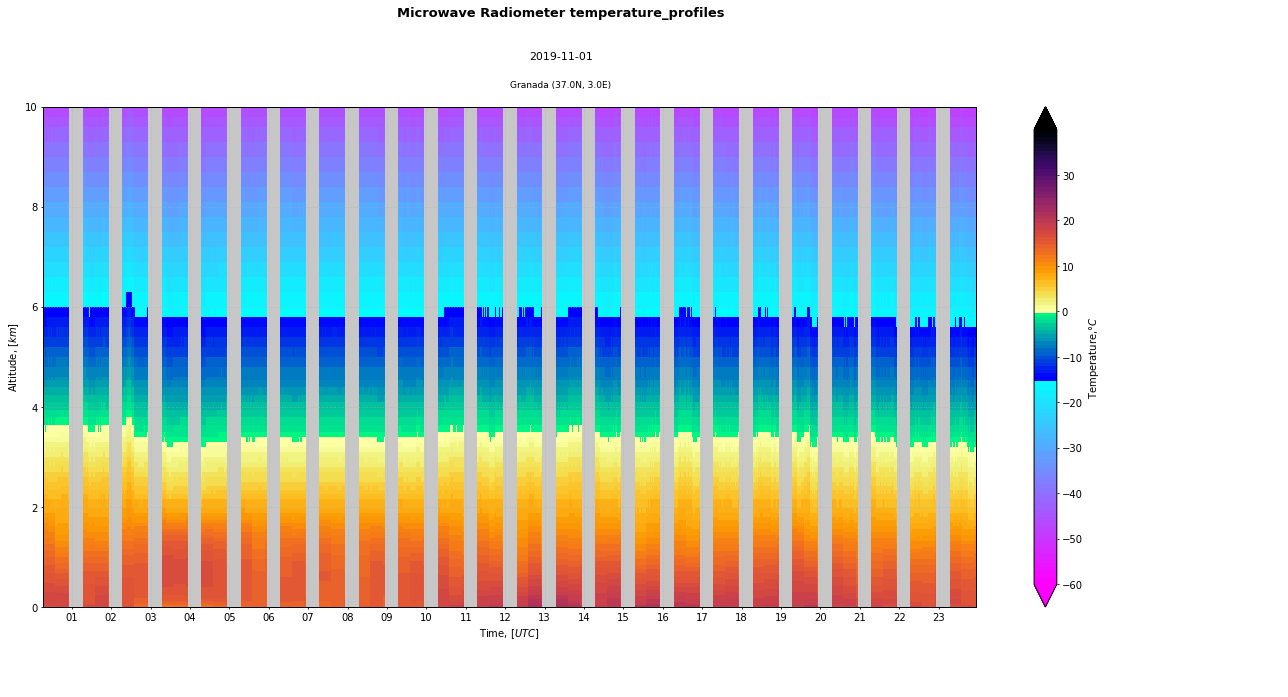

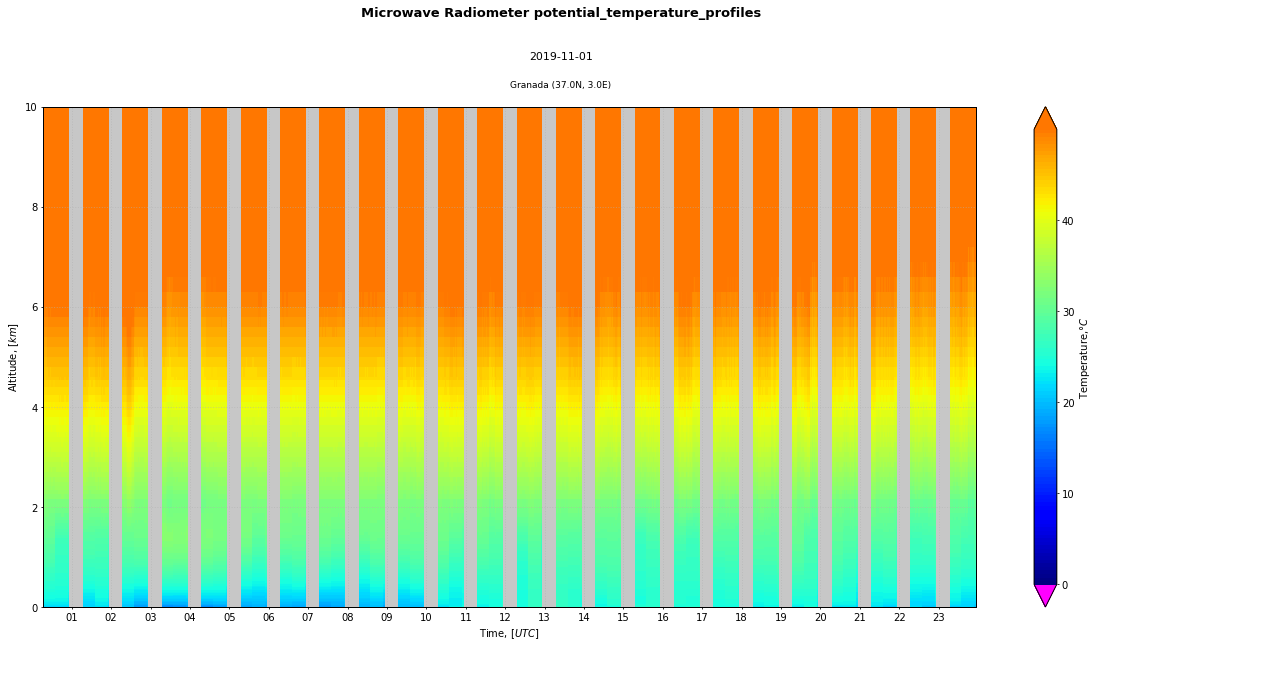

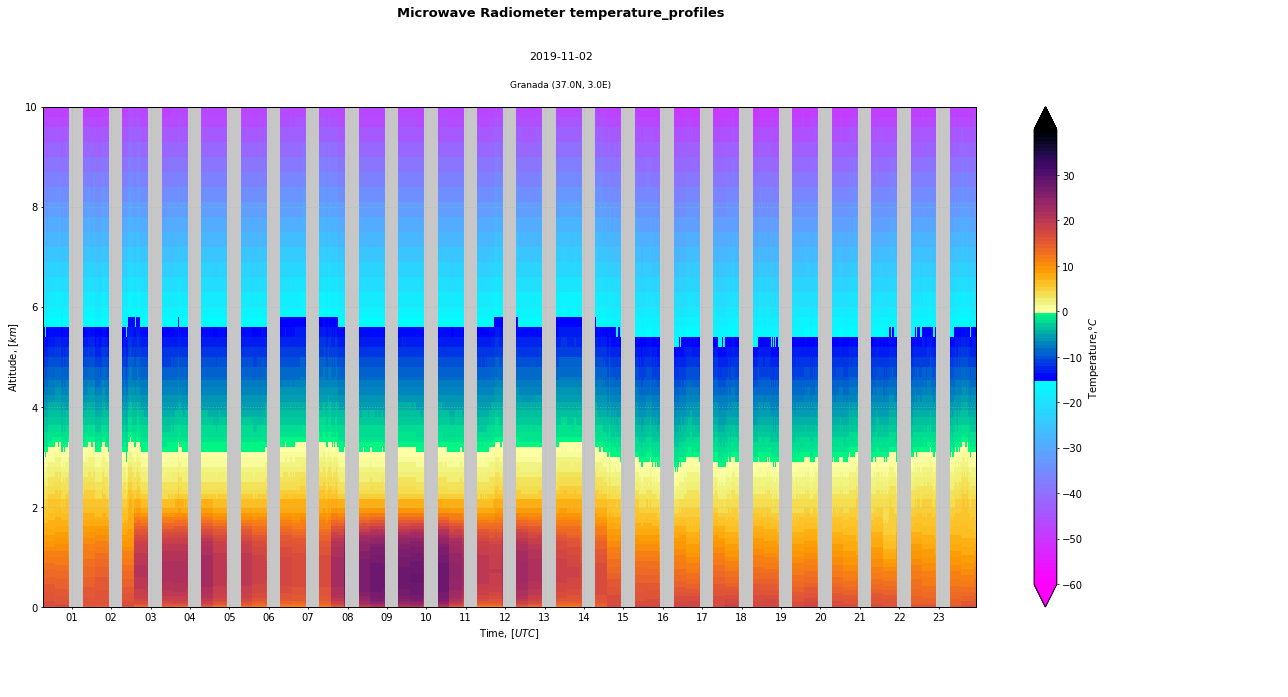

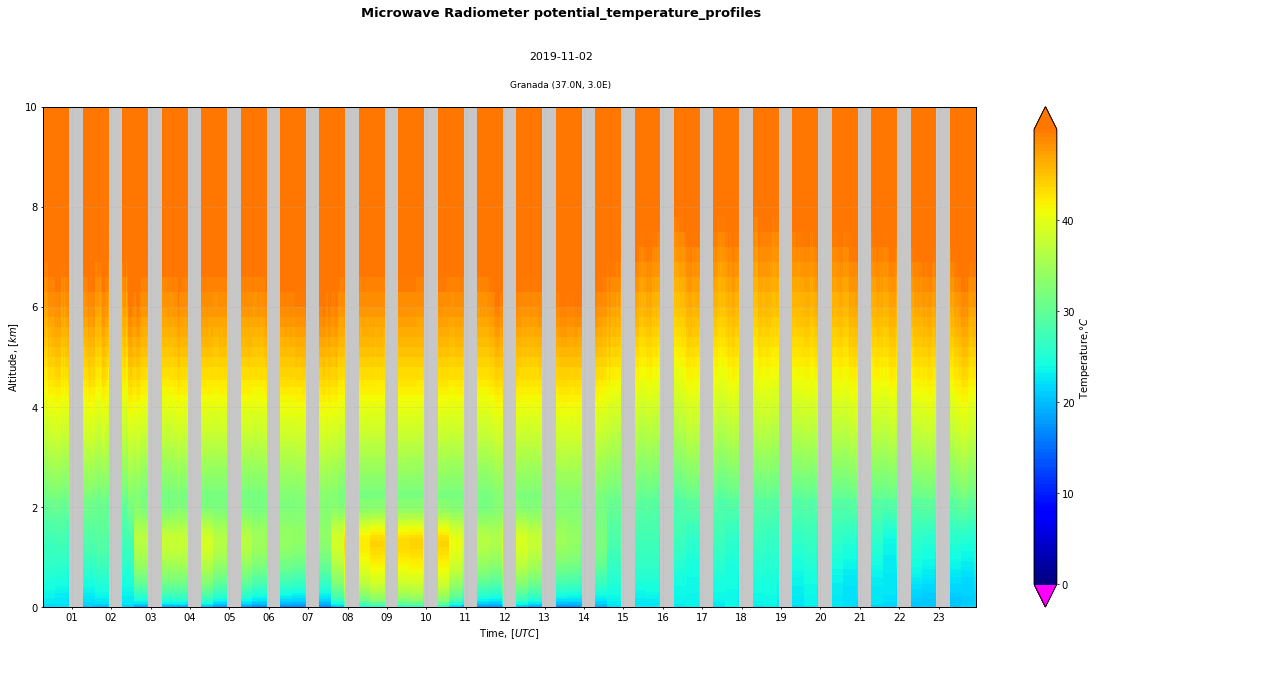

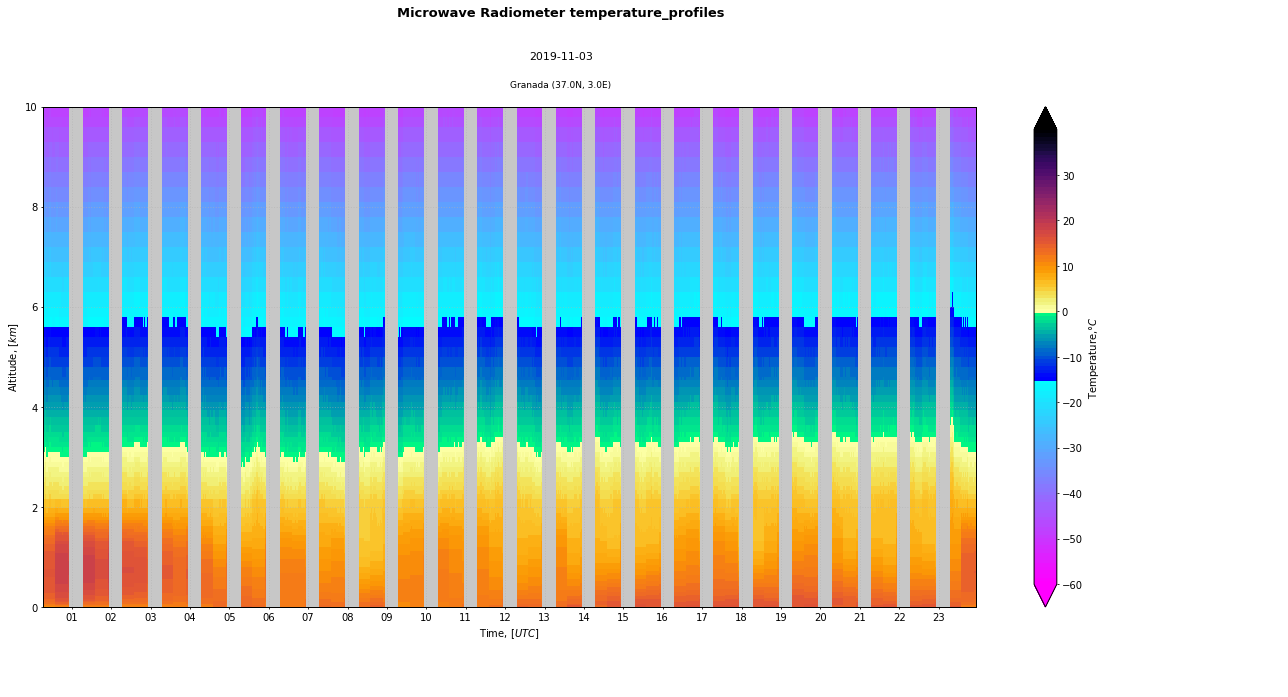

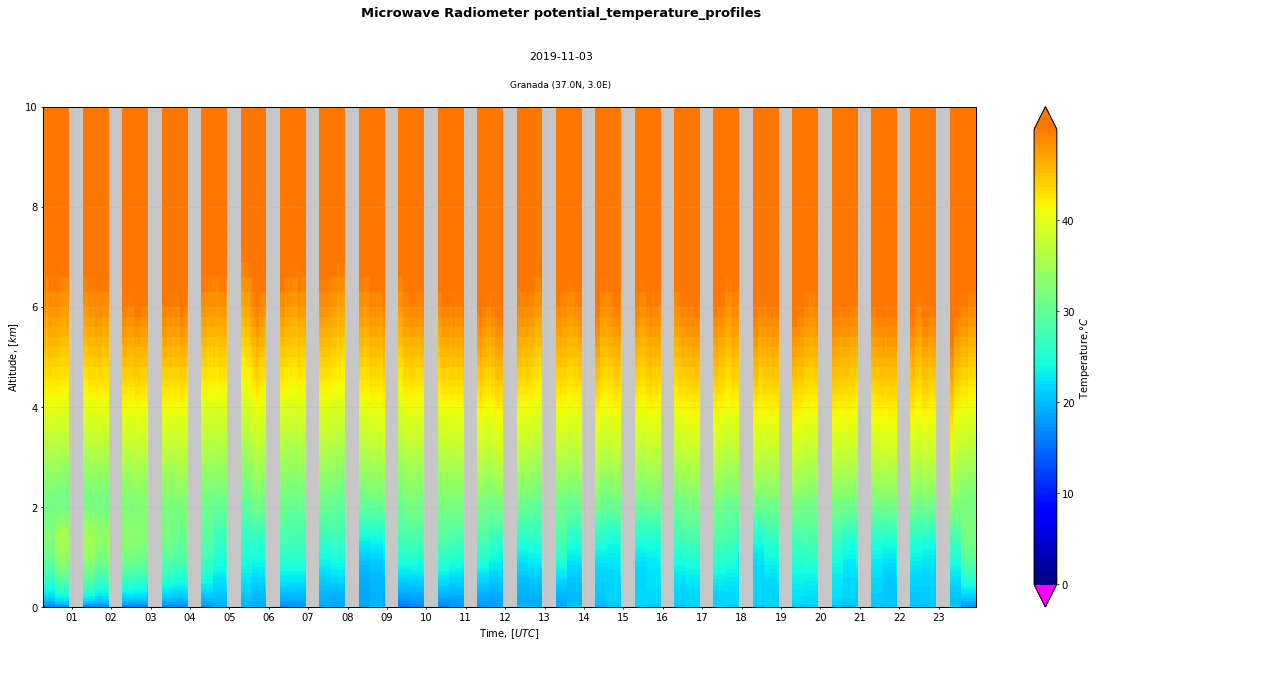

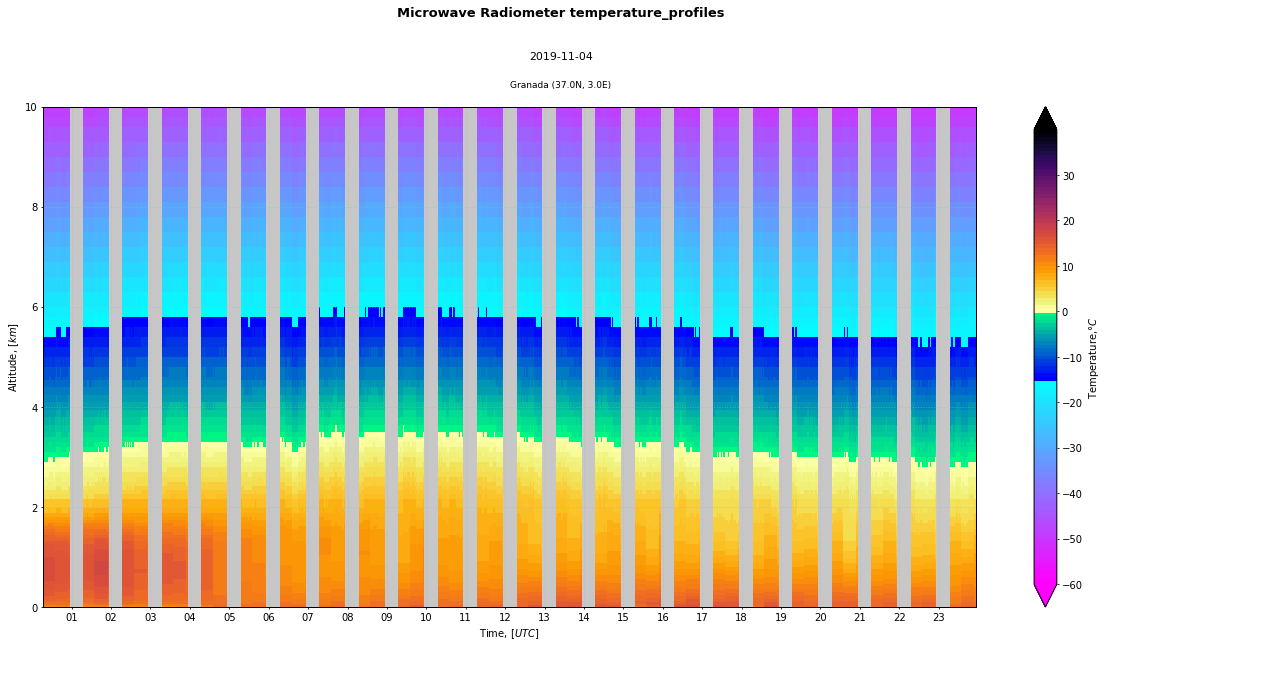

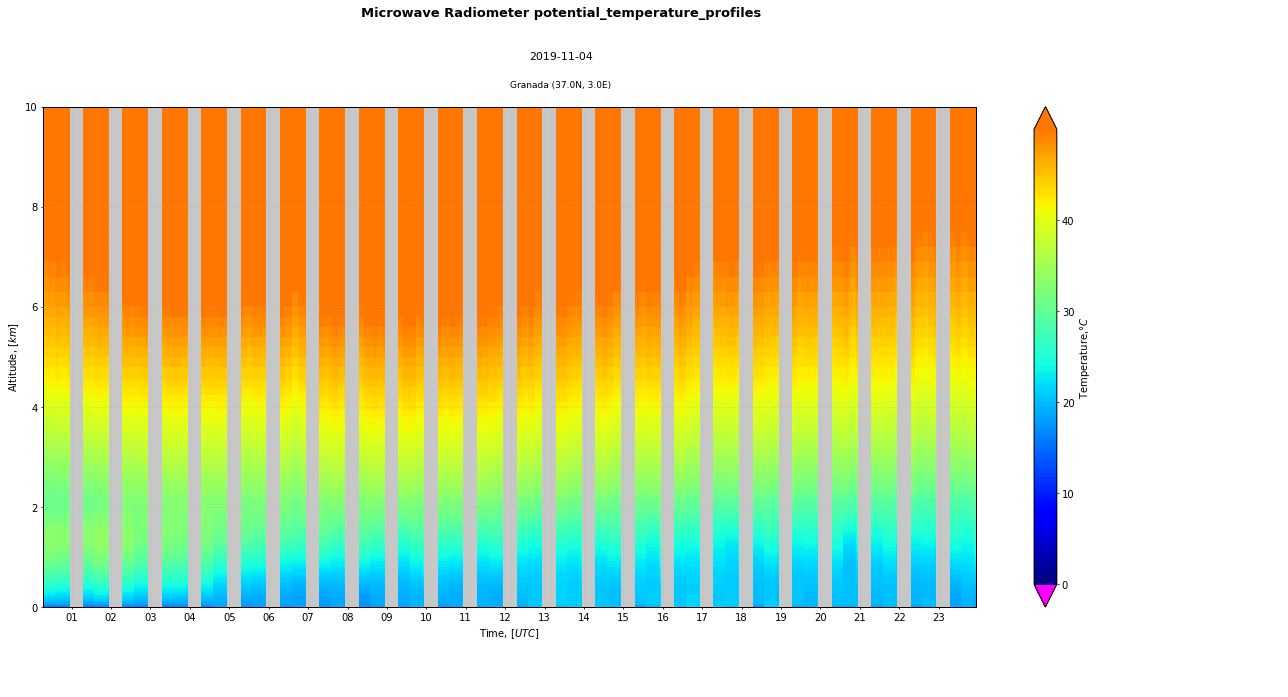

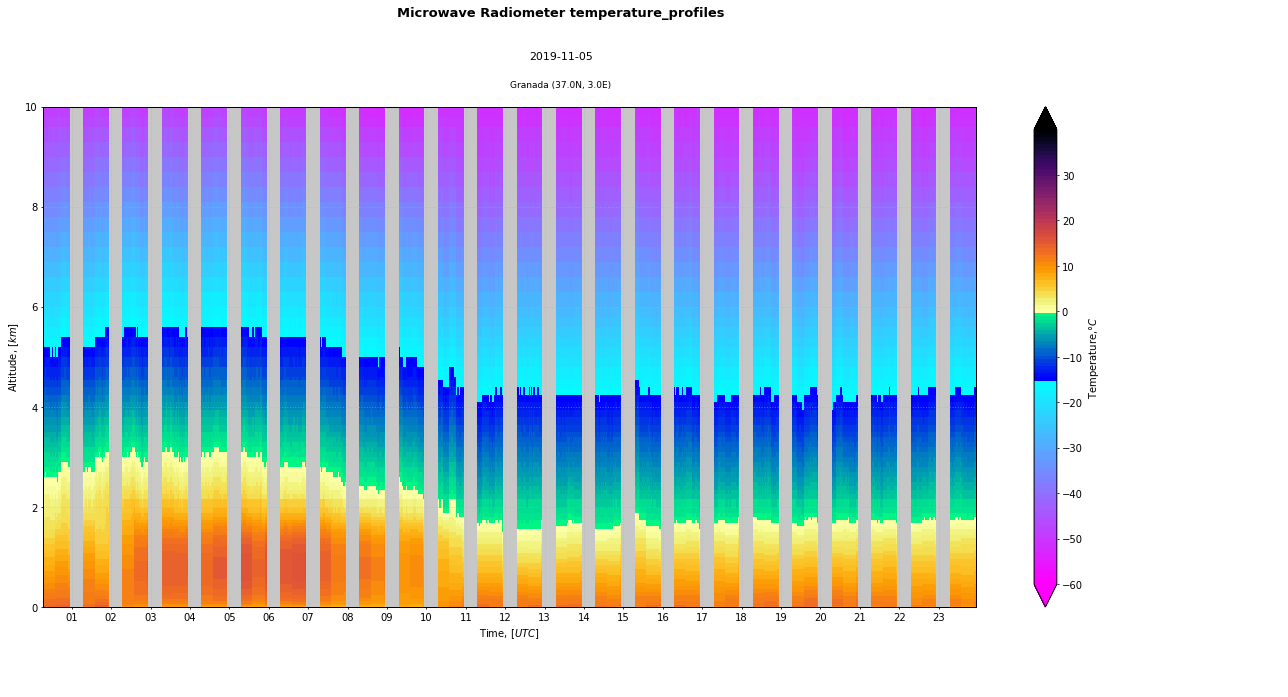

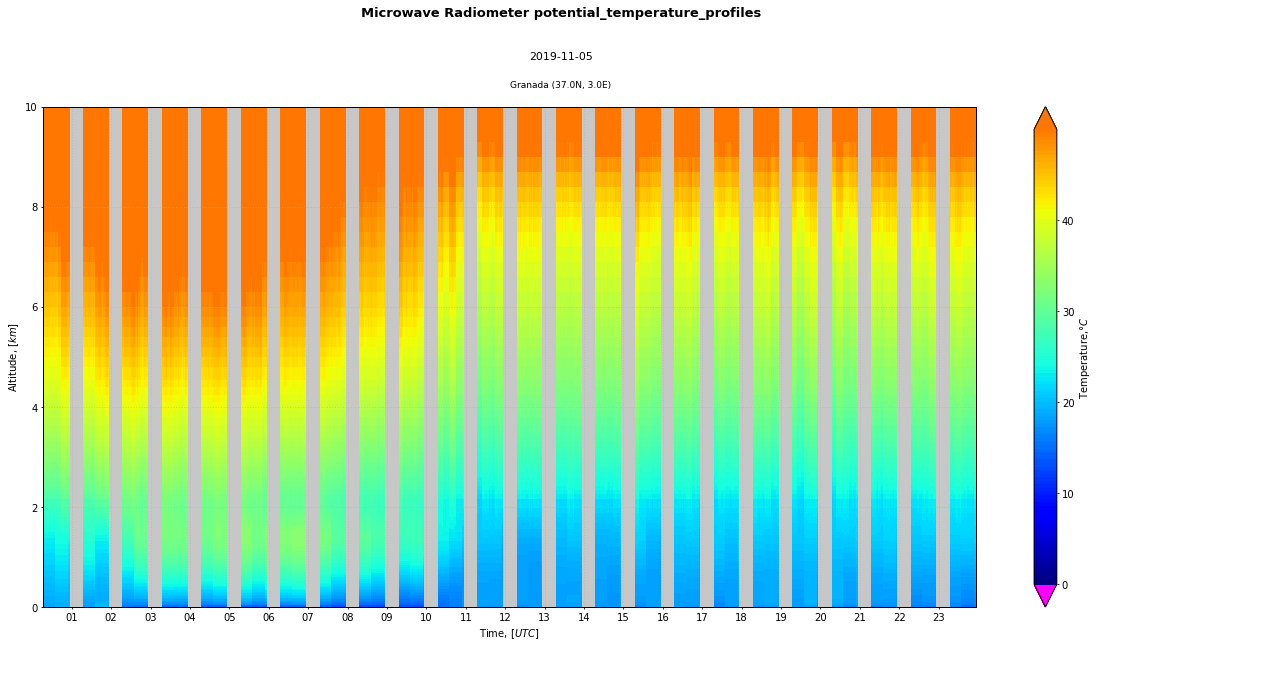

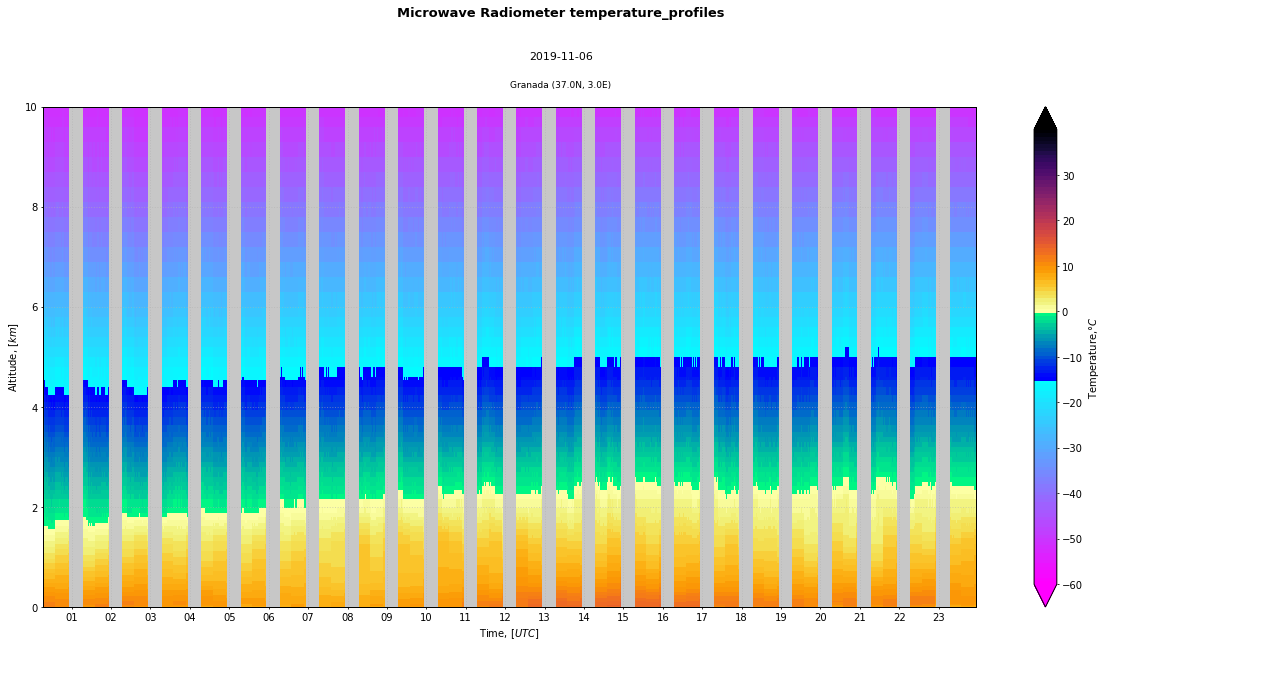

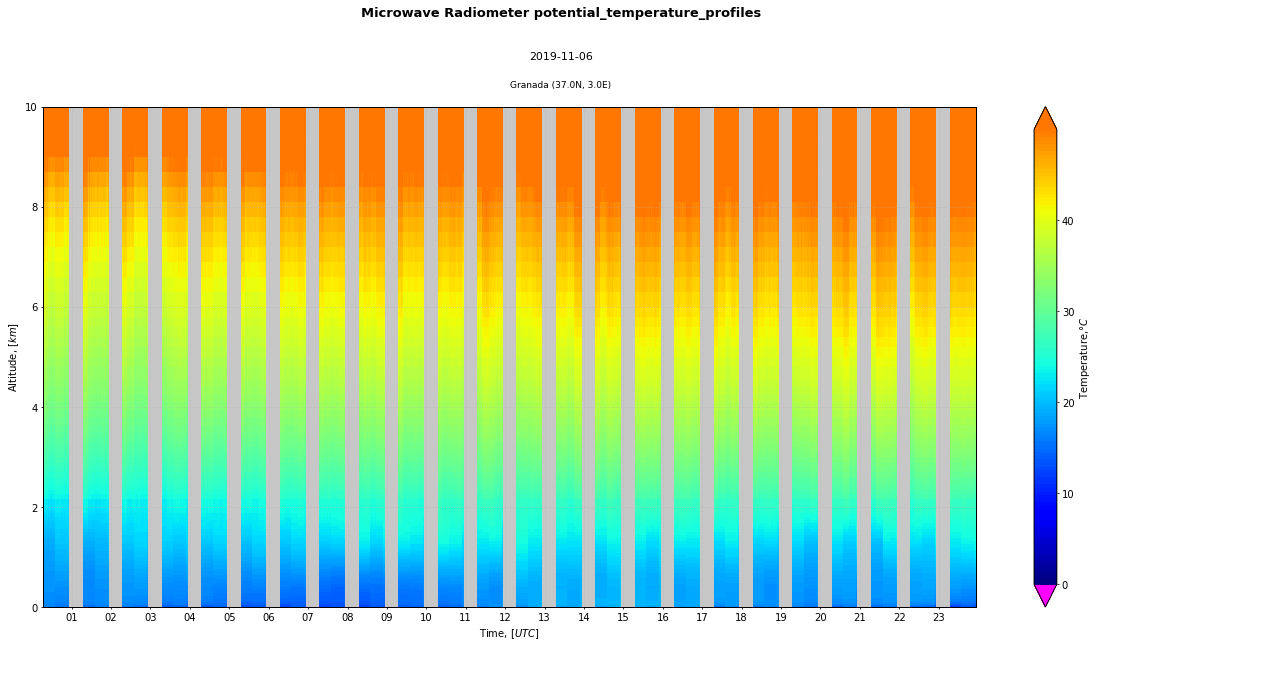

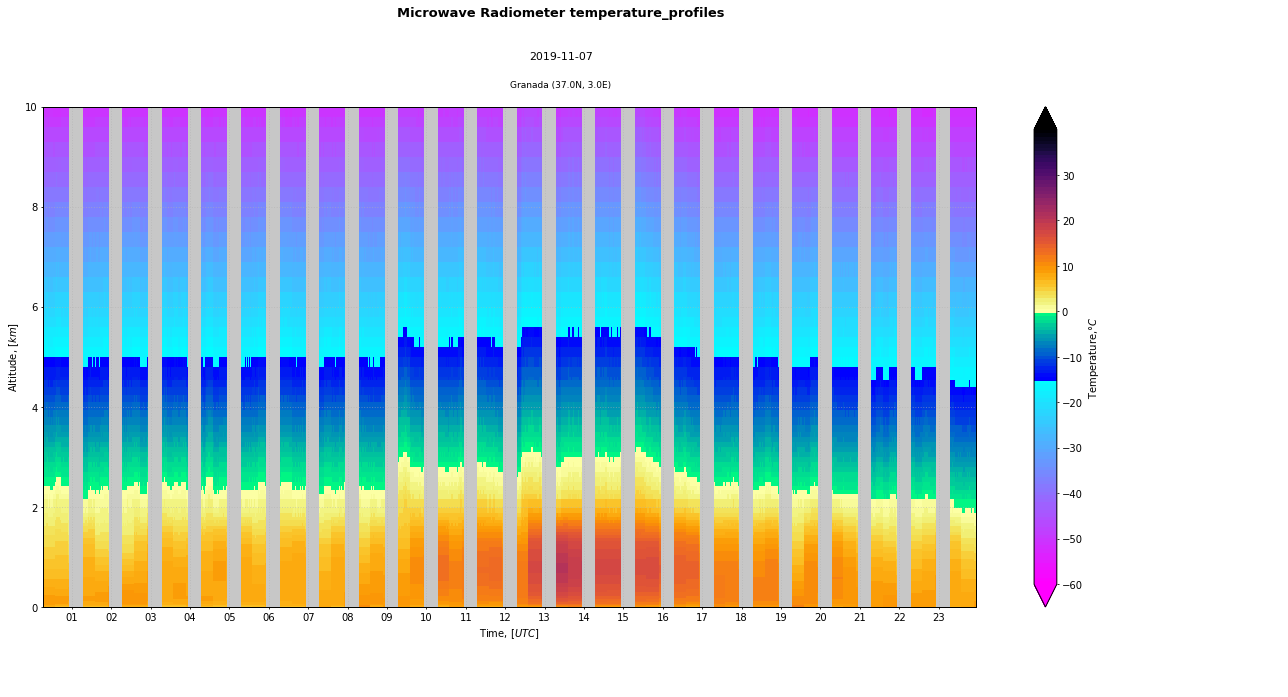

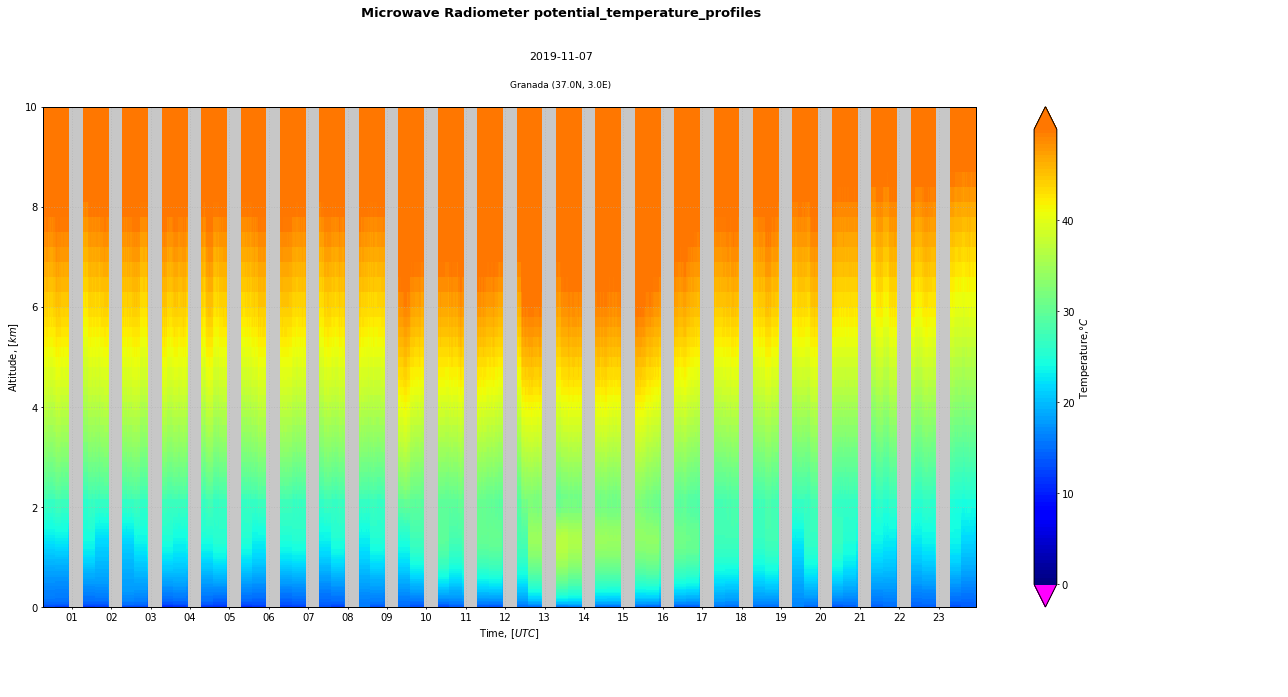

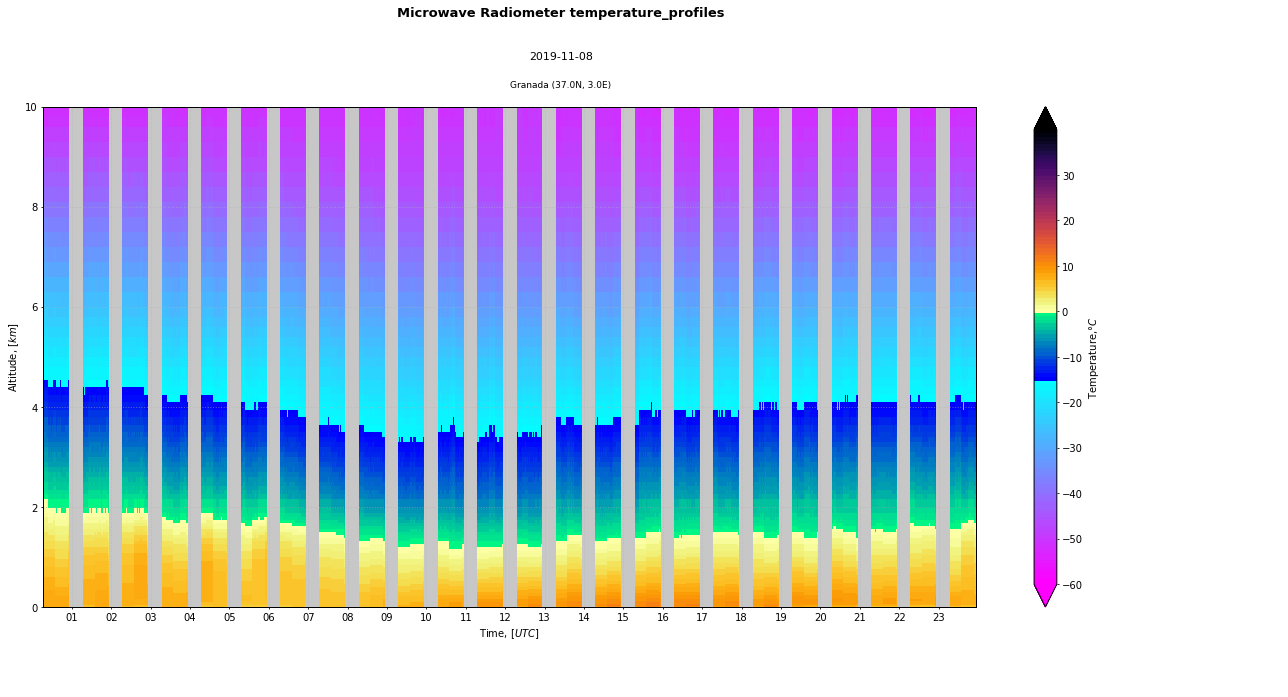

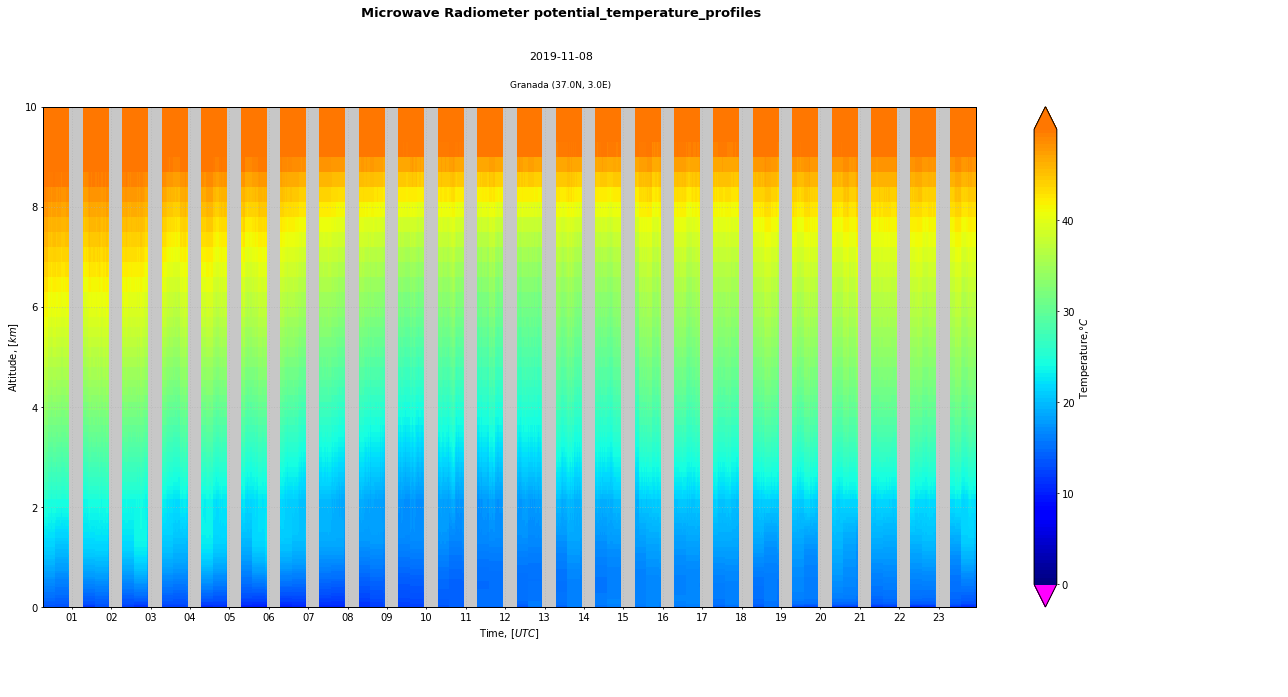

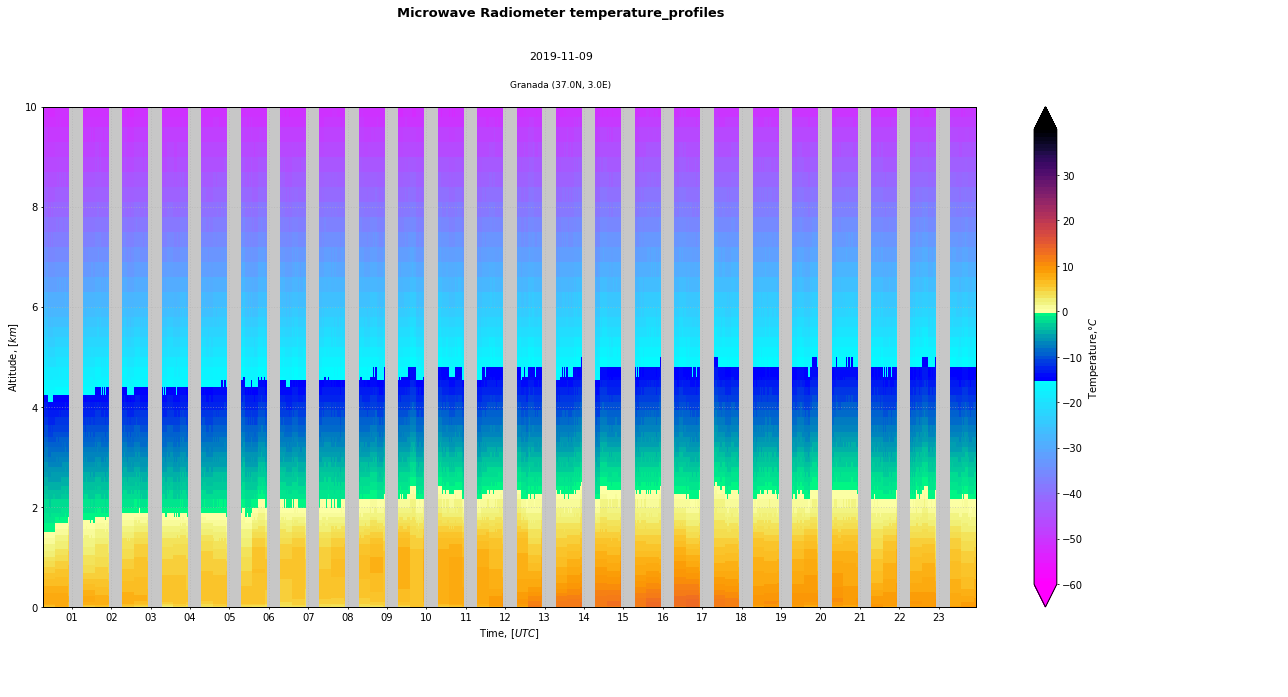

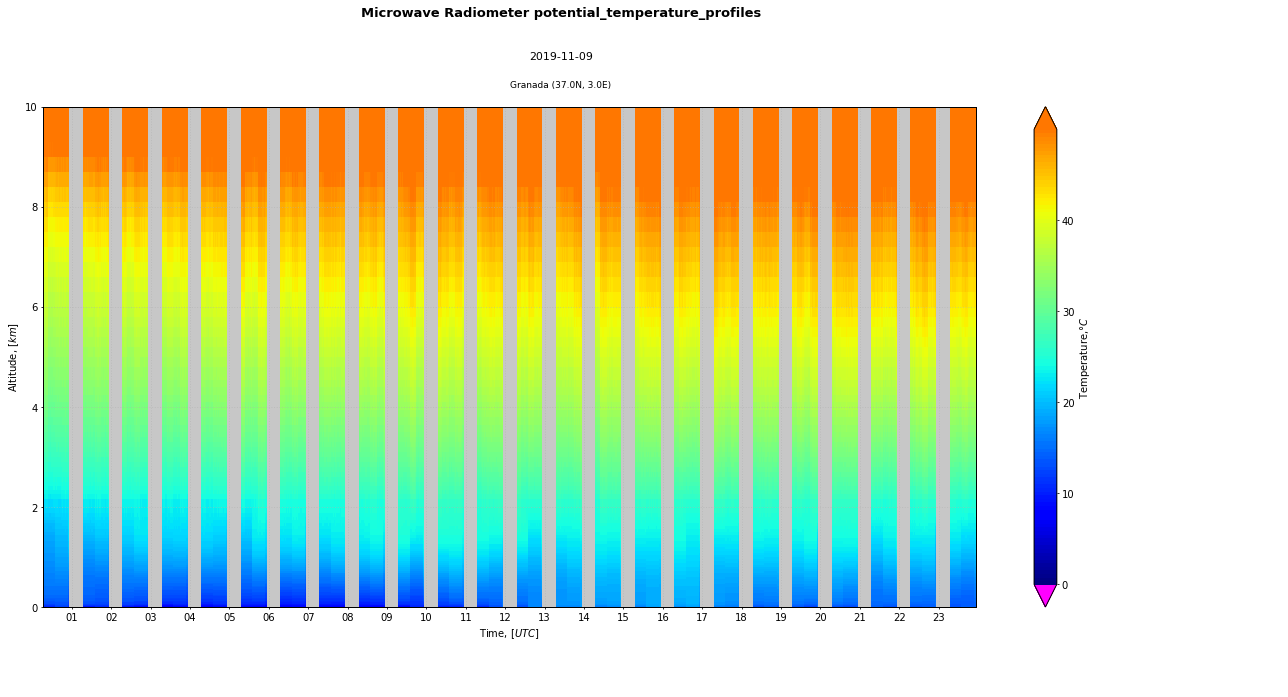

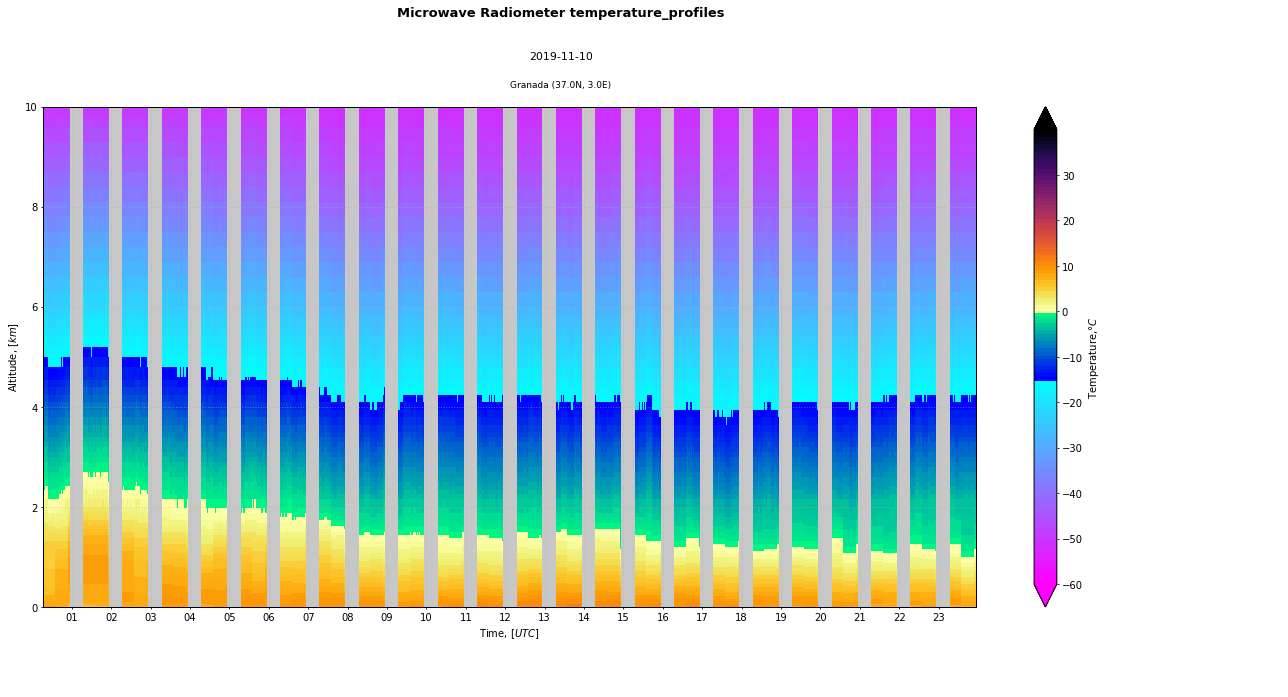

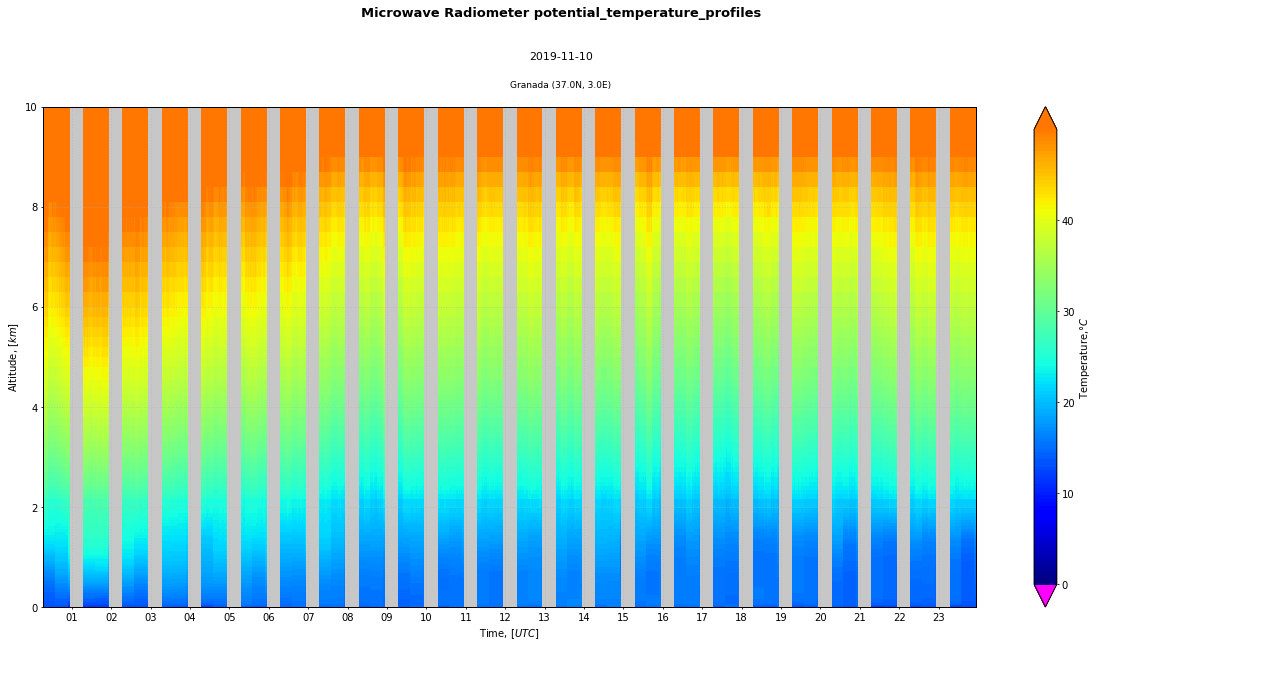

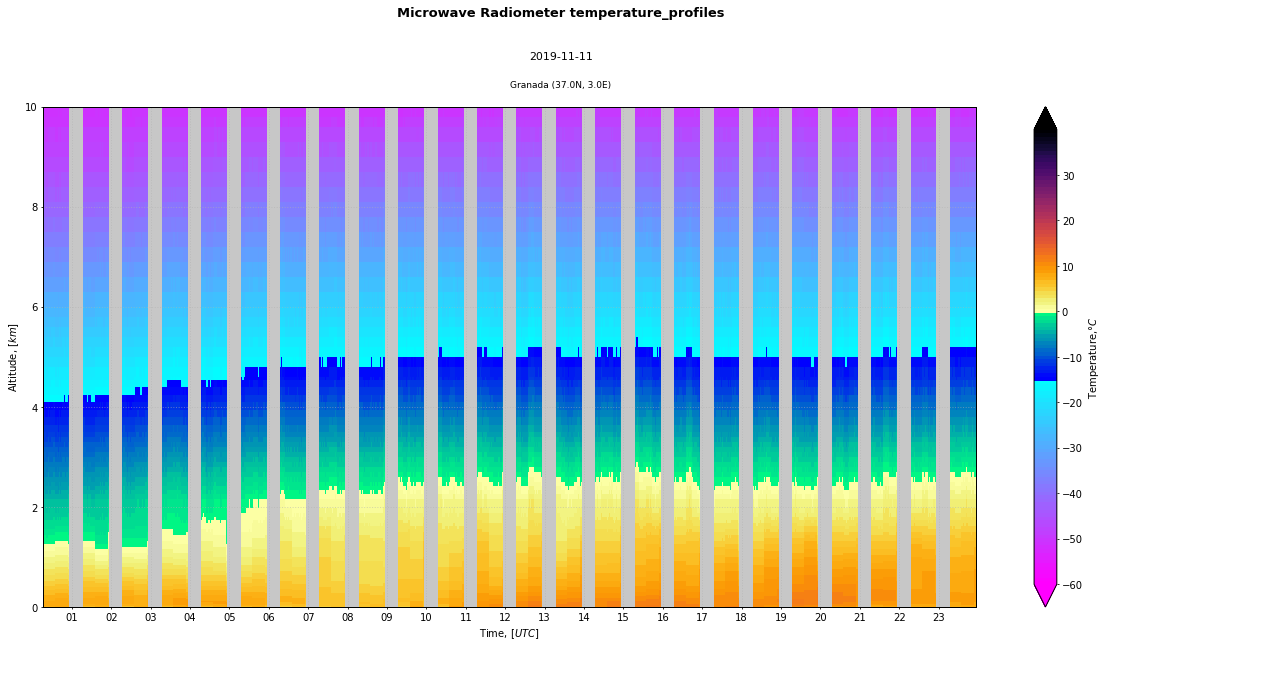

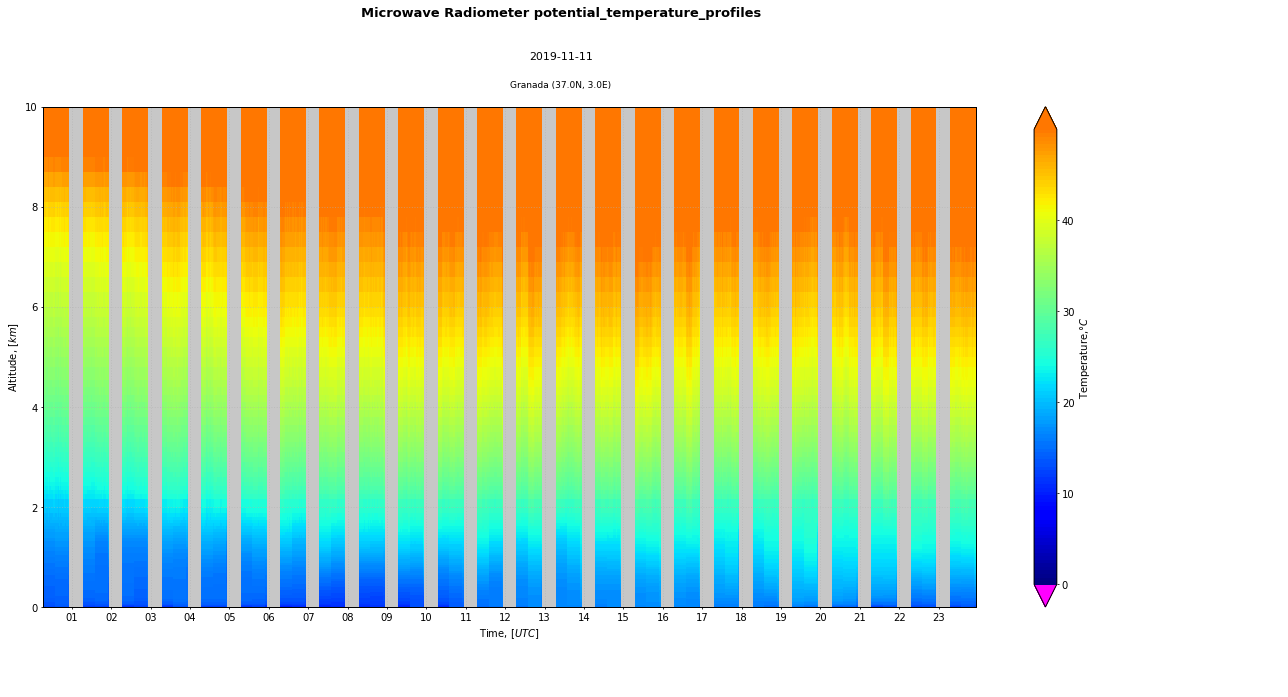

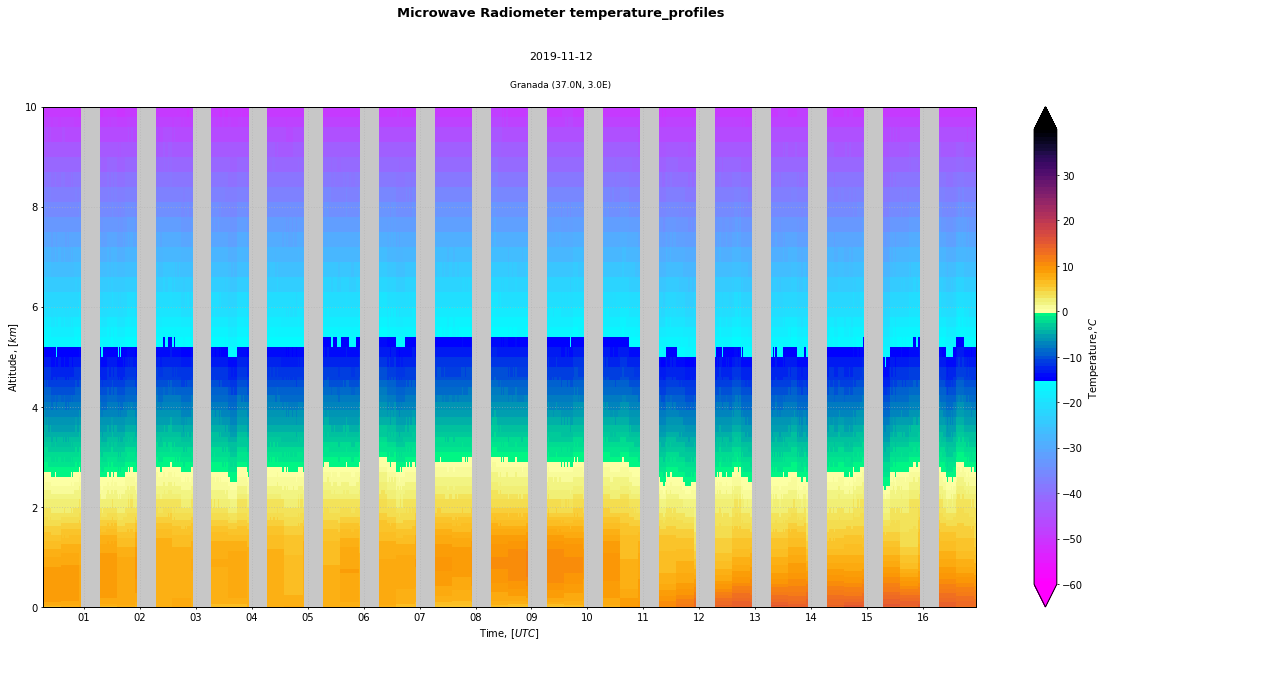

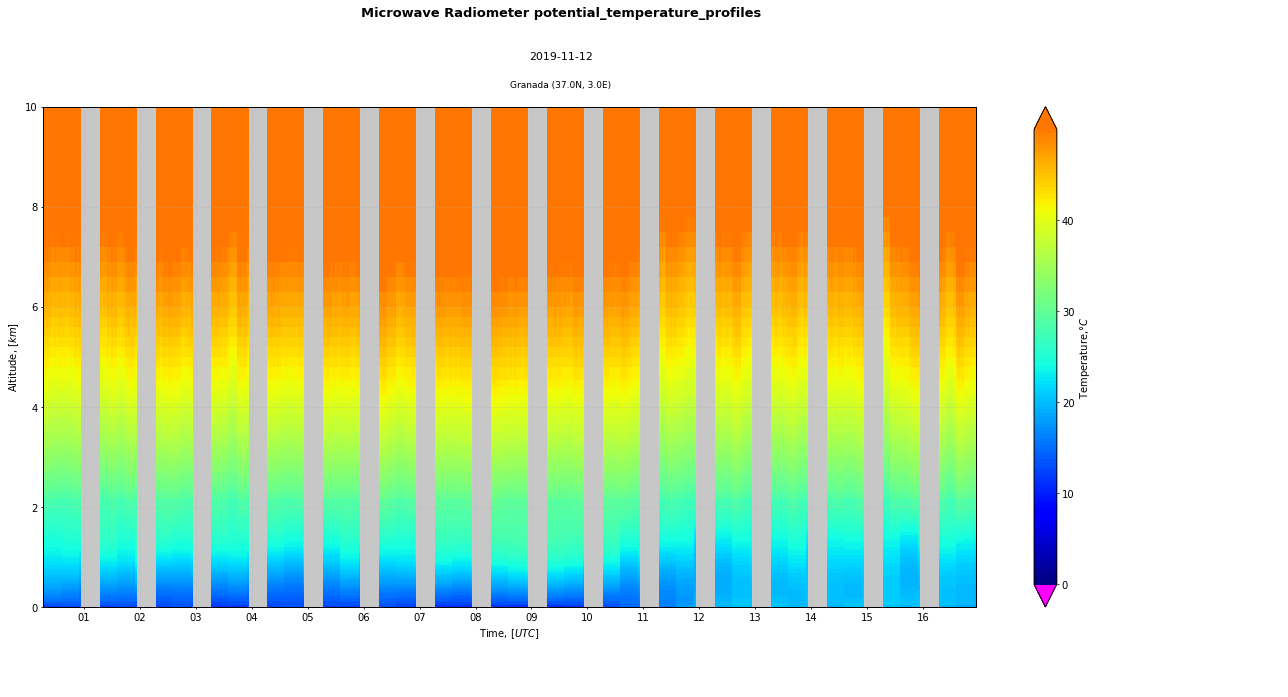

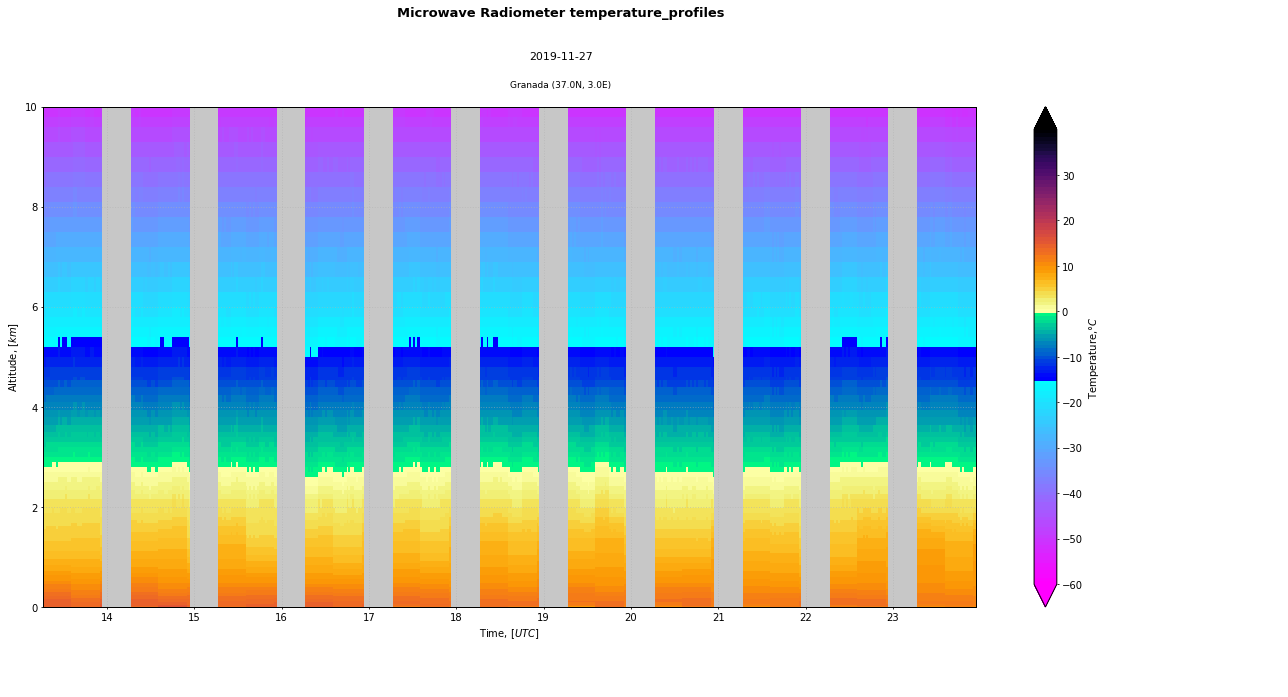

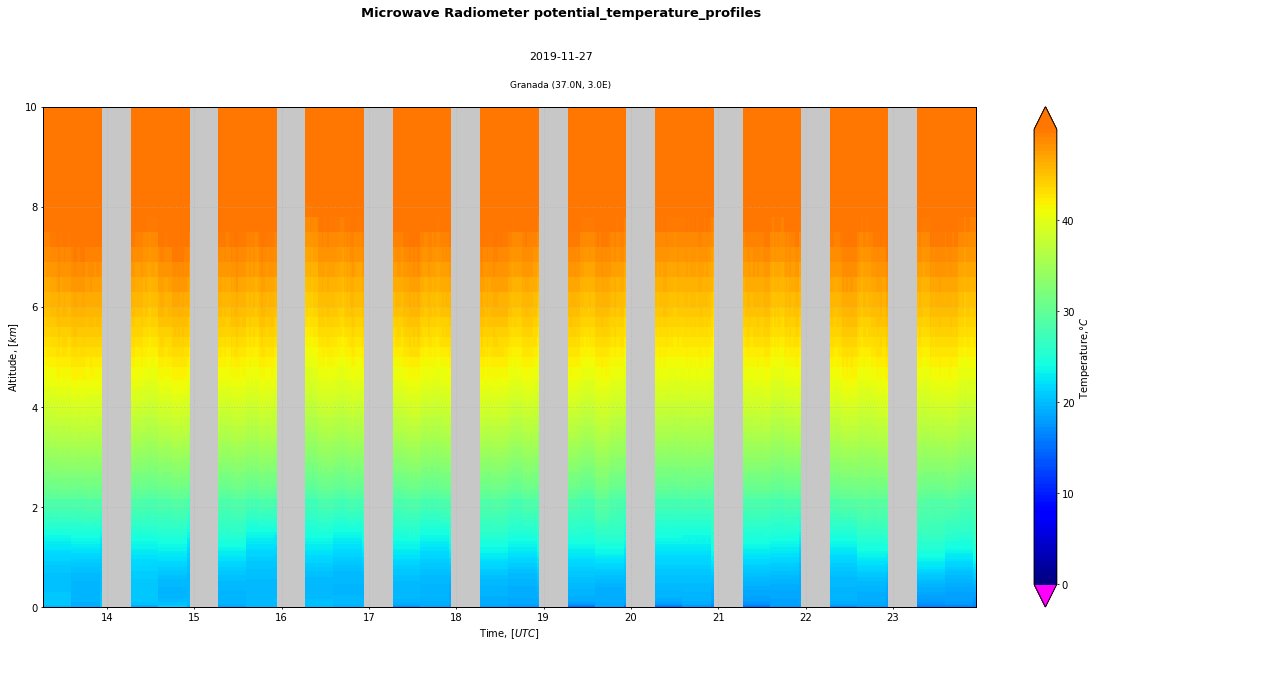

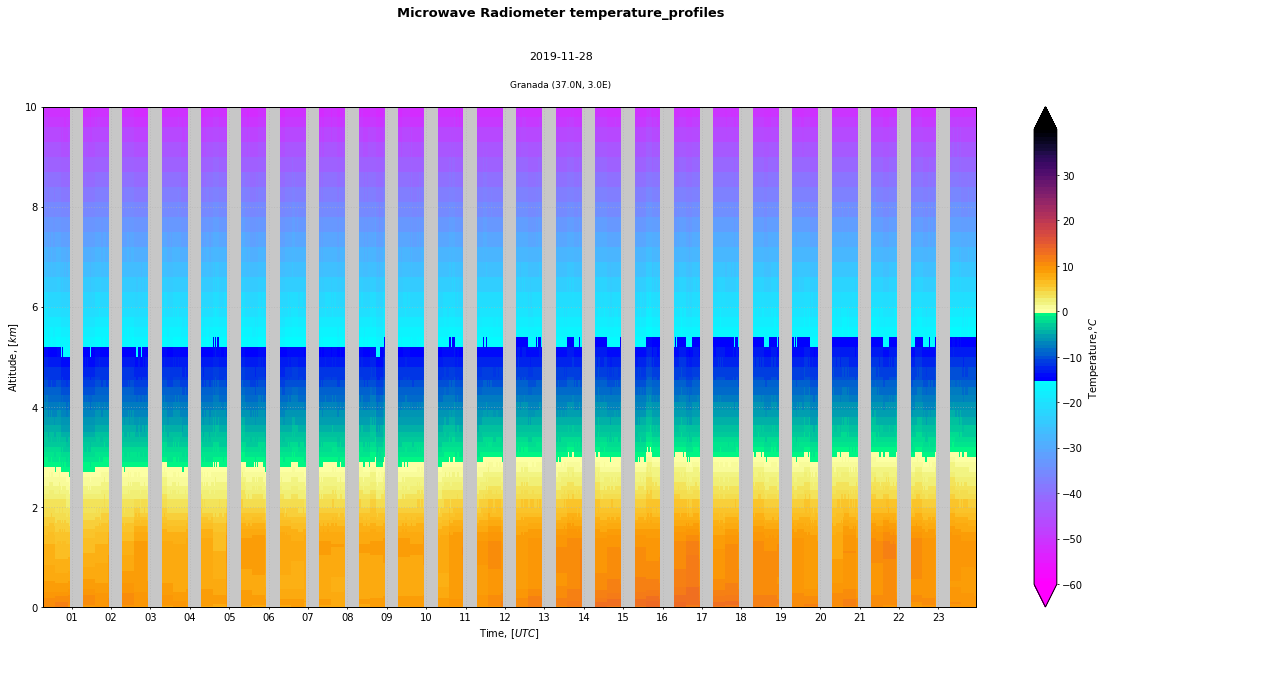

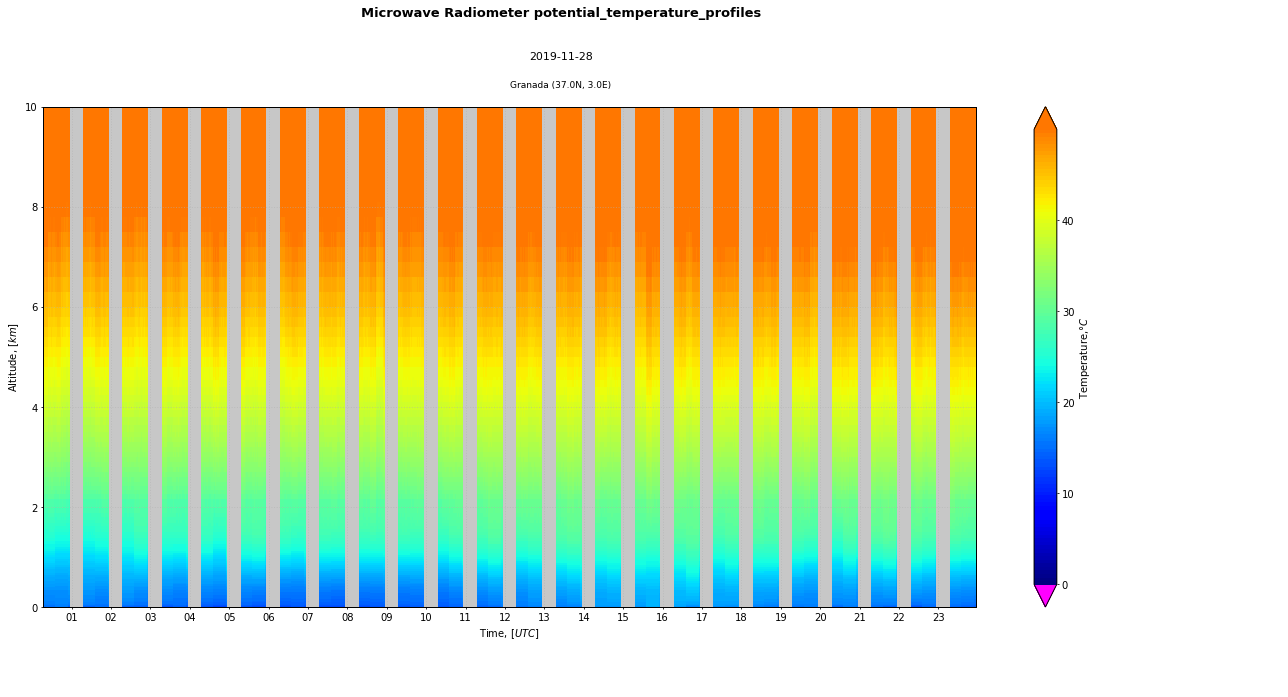

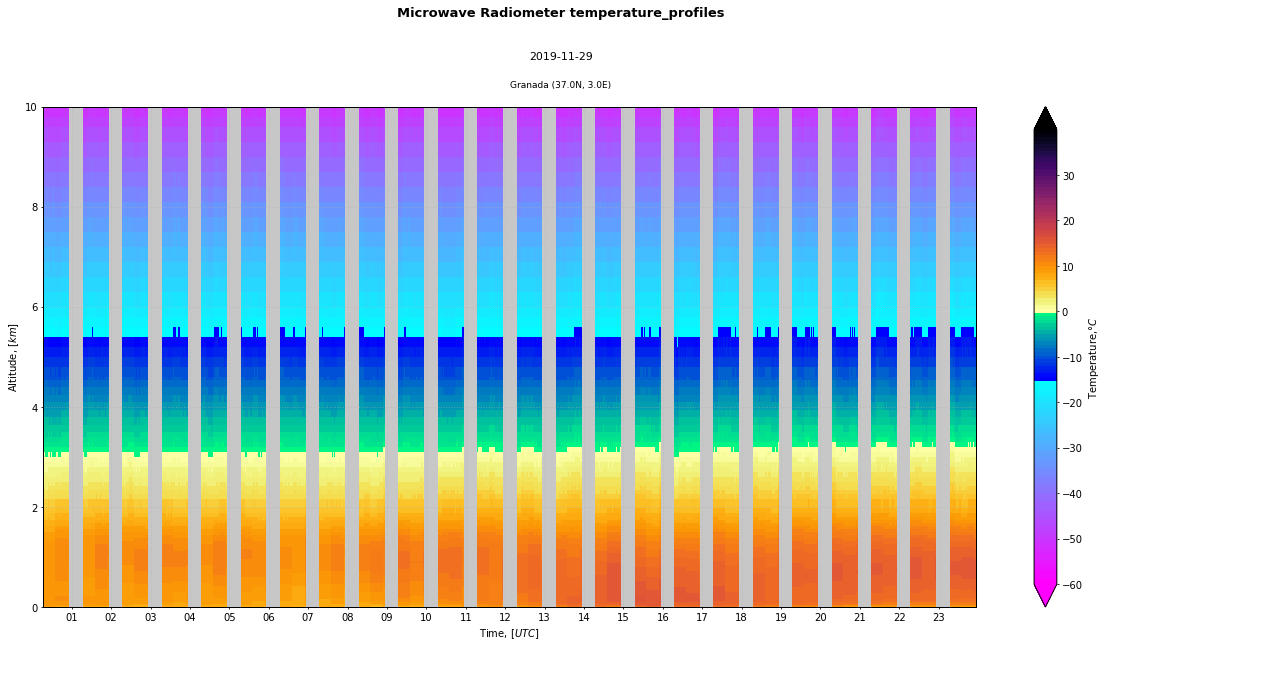

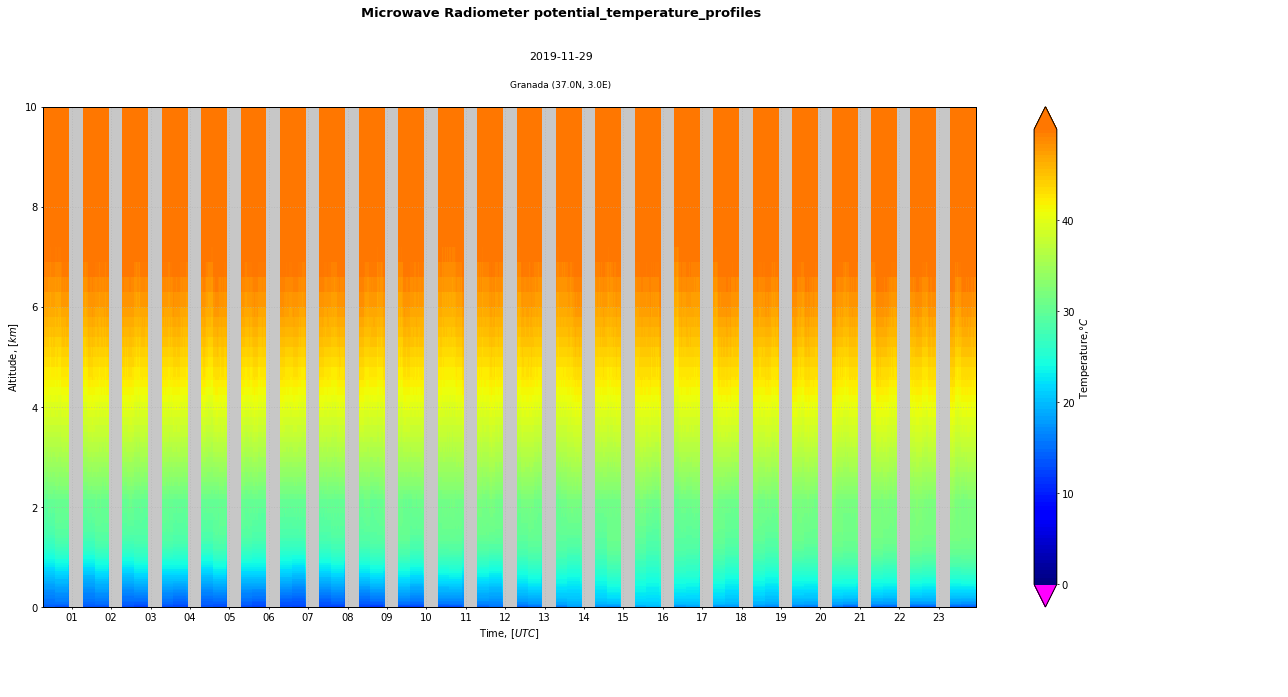

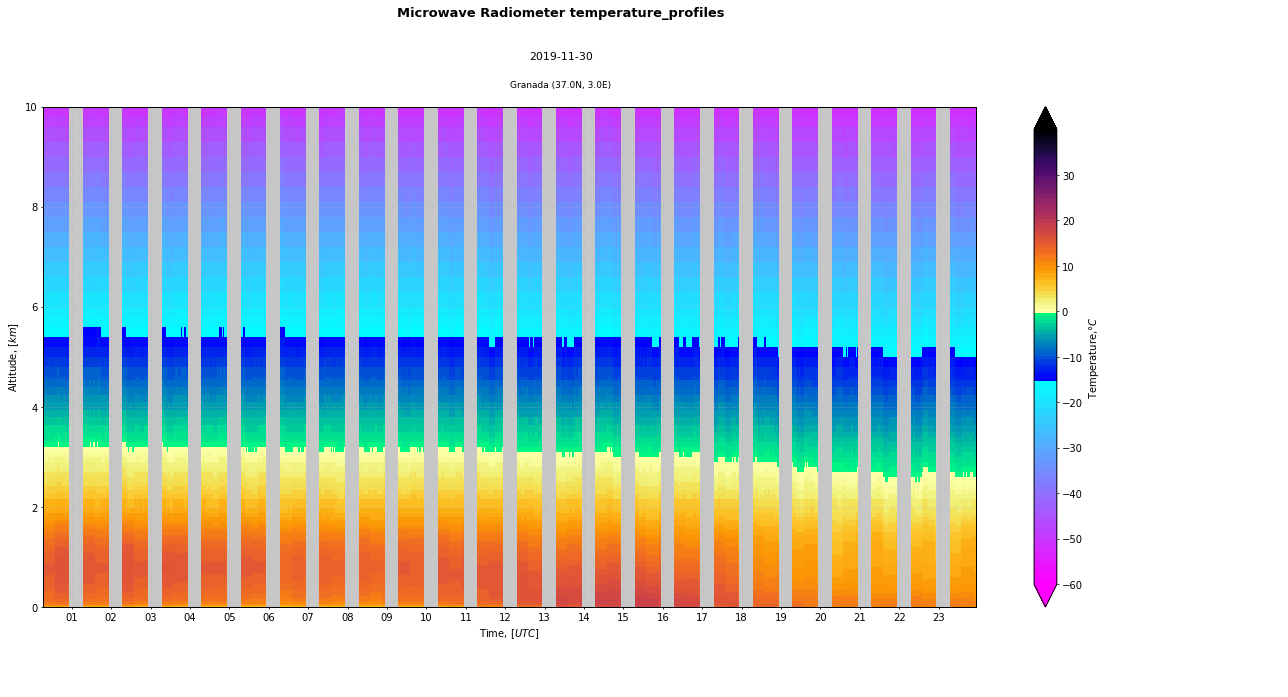

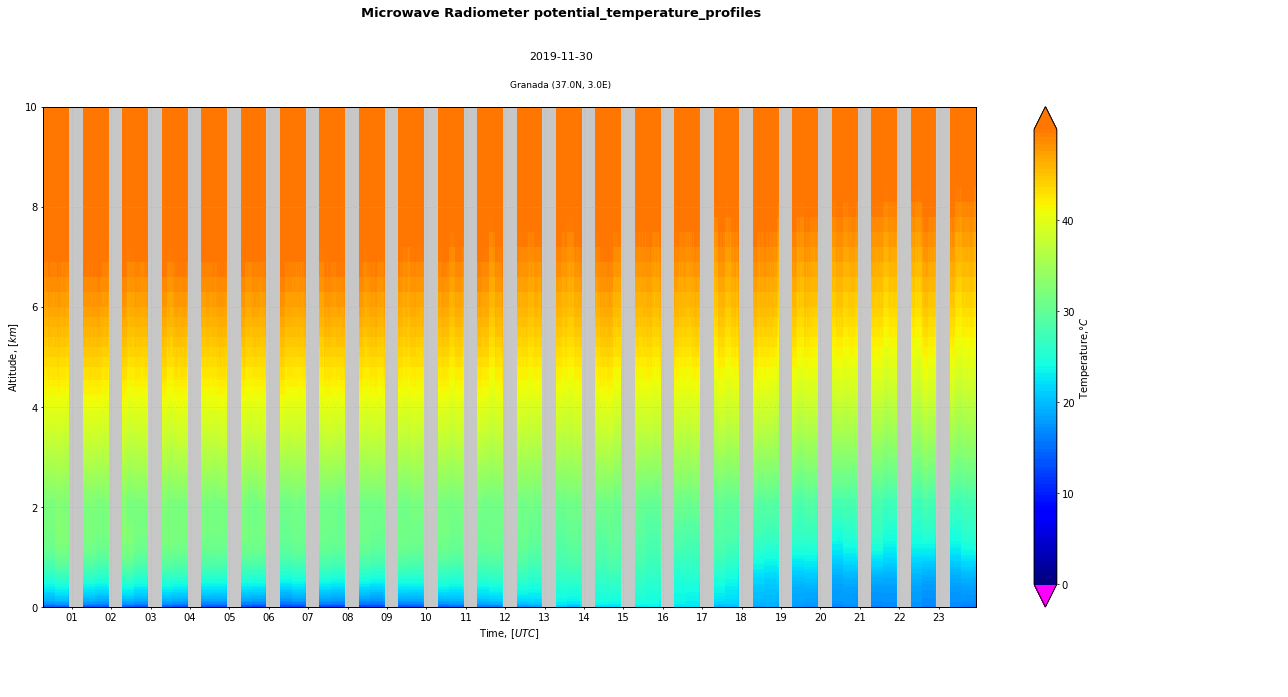

In [6]:
# 1 mes entero

# maindir_mwr = 'Y:\datos\RPG-HATPRO\Data\Y2019\M07\D28'
maindir_mwr = 'Y:\datos\RPG-HATPRO\Data'
mwrfile = 'ZENITH_*.CMP.TPC.NC'
mwrmet = 'ZENITH_*.MET.NC'

year = '2019'
month = '11'
days = np.arange(1,32)

# figdir = os.getcwd()
figdir = 'G:\Mi unidad\\00.INVESTIGACION\RADAR\Quicklooks'
plt_conf = {}
plt_conf['gapsize'] = 'default'
plt_conf['y_min'] = 0.
plt_conf['y_max'] = 10.
plt_conf['coeff'] = 2.   
variables2plot = (0,1)


for _day in days:

    dirfile = os.path.join(maindir_mwr,'Y'+year, 'M'+month, 'D0'+str(_day), mwrfile)
    dirfilemet = os.path.join(maindir_mwr,'Y'+year, 'M'+month, 'D0'+str(_day), mwrmet)
    if ((os.path.isfile(dirfile)==True), (os.path.isfile(dirfilemet) == True)):
#         if (os.path.isfile(dirfile)==True) && (os.path.isfile(dirfilemet) == True):

        a3 = plot_mwr_variables(dirfile, dirfilemet, variables2plot, plt_conf, figdir)

    dirfile = os.path.join(maindir_mwr,'Y'+year, 'M'+month, 'D'+str(_day), mwrfile)
    dirfilemet = os.path.join(maindir_mwr,'Y'+year, 'M'+month, 'D'+str(_day), mwrmet)
    if ((os.path.isfile(dirfile)==True), (os.path.isfile(dirfilemet) == True)):
#         if (os.path.isfile(dirfile)==True) && (os.path.isfile(dirfilemet) == True):

        a3 = plot_mwr_variables(dirfile, dirfilemet, variables2plot, plt_conf, figdir)

In [ ]:
def daily_quicklook(filelist, figdirectory):  
    
    plt_conf = {}
    plt_conf['gapsize'] = 'default'
    plt_conf['y_min'] = 0.
    plt_conf['y_max'] = 10.
    plt_conf['coeff'] = 2.   
    variables2plot = (0,1)
    plot_mwr_variables(os.path.join(maindir_mwr,mwrfile), os.path.join(maindir_mwr,mwrmet), variables2plot, plt_conf, figdir)
